In [107]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport somatic_mut_clock, utils
%autoreload 1
import get_data, utils, mutation_features, methylation_pred, somatic_mut_clock

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr, pearsonr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
import xgboost as xgb
import shap
from pymemesuite.common import MotifFile
import Bio.SeqIO
from pymemesuite.common import Sequence
from pymemesuite.fimo import FIMO


%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


# TCGA Data

In [3]:
# qnorm data
all_mut_w_age_df, illumina_cpg_locs_df, all_methyl_age_df_t, matrix_qtl_dir, covariate_fn = get_data.read_tcga_data()

reading in data
Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


In [56]:
# n choose k
n = 273205 - 3
k = 2
from math import factorial
n_choose_k = factorial(n) / (factorial(k) * factorial(n - k))
n_choose_k

37319529801.0

In [65]:
motif_occurence_df = pd.read_parquet(
        "/cellar/users/zkoch/methylation_and_mutation/data/methylation_motifs_weiWang/motif_occurences/motif_occurences_combined_15kb.parquet"
        )

In [68]:
len(motif_occurence_df['motif_name'].value_counts())

42

In [71]:
mut_feat_tcga_dict = {}
somage_tcga_dict = {}

# for each cv iteration
for cv_num in [0]:
    # create a mutation features object
    mut_feat_tcga = mutation_features.mutationFeatures(
        all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
        all_methyl_age_df_t = all_methyl_age_df_t, out_dir = "./", 
        consortium = 'TCGA', dataset = '', cross_val_num = cv_num,
        matrix_qtl_dir = matrix_qtl_dir,
        covariate_fn = covariate_fn, motif_occurence_df = pd.DataFrame()
    )
    # add to dictionary
    mut_feat_tcga_dict[cv_num] = mut_feat_tcga
    # and create a somage object from the seperate somage outputs
    somage_tcga = somatic_mut_clock.mutationClock.construct_from_paths(
        somage_path = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output",
        directory_glob = f"TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_*startTopCpGs_500extendAmount_{cv_num}crossValNum",
        file_suffix = "xgboost_nonebaseline_agg_only",
        mut_feat = mut_feat_tcga,
        illumina_cpg_locs_df = illumina_cpg_locs_df,
        all_methyl_age_df_t = all_methyl_age_df_t,
        out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output"
        )
    # read in pre-comp prediction performance by dset
    #somage_tcga.performance_by_dataset_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/062623_tcga_somage_output/pred_methyl_and_perf_by_dset/performance_by_dataset_CV{cv_num}.parquet")
    # add to dictionary
    somage_tcga_dict[cv_num] = somage_tcga

Creating soMage object


Loading performance data: 100%|██████████| 262/262 [00:10<00:00, 25.59it/s]


In [5]:
mut_feat_tcga_all_feat_dict = {}
somage_tcga_all_feat_dict = {}

# for each cv iteration
for cv_num in [0]:
    # create a mutation features object
    mut_feat_tcga = mutation_features.mutationFeatures(
        all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
        all_methyl_age_df_t = all_methyl_age_df_t, out_dir = "./", 
        consortium = 'TCGA', dataset = '', cross_val_num = cv_num,
        matrix_qtl_dir = matrix_qtl_dir,
        covariate_fn = covariate_fn, motif_occurence_df = pd.DataFrame()
    )
    # add to dictionary
    mut_feat_tcga_all_feat_dict[cv_num] = mut_feat_tcga
    # and create a somage object from the seperate somage outputs
    somage_tcga = somatic_mut_clock.mutationClock.construct_from_paths(
        somage_path = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output",
        directory_glob = f"TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_*startTopCpGs_500extendAmount_{cv_num}crossValNum",
        file_suffix = "xgboost_nonebaseline_all_feats",
        mut_feat = mut_feat_tcga,
        illumina_cpg_locs_df = illumina_cpg_locs_df,
        all_methyl_age_df_t = all_methyl_age_df_t,
        out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output"
        )
    # read in pre-comp prediction performance by dset
    #somage_tcga.performance_by_dataset_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/062623_tcga_somage_output/pred_methyl_and_perf_by_dset/performance_by_dataset_CV{cv_num}.parquet")
    # add to dictionary
    somage_tcga_all_feat_dict[cv_num] = somage_tcga

Creating soMage object


Loading performance data: 100%|██████████| 262/262 [00:12<00:00, 21.28it/s]


In [6]:
somage_scramble_tcga_dict = {}

# for each cv iteration
for cv_num in [0]:
    # and create a somage object from the seperate somage outputs
    somage_scramble_tcga = somatic_mut_clock.mutationClock.construct_from_paths(
        somage_path = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output",
        directory_glob = f"TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_*startTopCpGs_500extendAmount_{cv_num}crossValNum",
        file_suffix = "xgboost_scramblebaseline_agg_only",
        mut_feat = mut_feat_tcga,
        illumina_cpg_locs_df = illumina_cpg_locs_df,
        all_methyl_age_df_t = all_methyl_age_df_t,
        out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output"
        )
    # read in pre-comp prediction performance by dset
    #somage_tcga.performance_by_dataset_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/062623_tcga_somage_output/pred_methyl_and_perf_by_dset/performance_by_dataset_CV{cv_num}.parquet")
    # add to dictionary
    somage_scramble_tcga_dict[cv_num] = somage_scramble_tcga

Creating soMage object


Loading performance data: 100%|██████████| 262/262 [00:07<00:00, 33.22it/s]


In [7]:
somage_scramble_tcga_all_feat_dict = {}

# for each cv iteration
for cv_num in [0]:
    # and create a somage object from the seperate somage outputs
    somage_scramble_tcga = somatic_mut_clock.mutationClock.construct_from_paths(
        somage_path = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output",
        directory_glob = f"TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_*startTopCpGs_500extendAmount_{cv_num}crossValNum",
        file_suffix = "xgboost_scramblebaseline_all_feats",
        mut_feat = mut_feat_tcga,
        illumina_cpg_locs_df = illumina_cpg_locs_df,
        all_methyl_age_df_t = all_methyl_age_df_t,
        out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output"
        )
    # read in pre-comp prediction performance by dset
    #somage_tcga.performance_by_dataset_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/062623_tcga_somage_output/pred_methyl_and_perf_by_dset/performance_by_dataset_CV{cv_num}.parquet")
    # add to dictionary
    somage_scramble_tcga_all_feat_dict[cv_num] = somage_scramble_tcga

Creating soMage object


Loading performance data: 100%|██████████| 262/262 [00:12<00:00, 21.51it/s]


#### Colocalization analysis

In [ ]:
# 1000 CpGs takes 1 hour to predict
# want to take the top X CpGs and predict 100 times
# => 1 hour for every 10 CpGs => 10 hours for 100 CpGs

In [168]:
# want to do in just 1 tissue type
best_predicted_cpgs = somage_tcga_dict[0].performance_by_dataset_df.query("dataset == 'STAD'").sort_values(
    by="AvP_methyl_pearson", ascending=False
    )['cpg'].values[:1000]

In [ ]:
new_feature_dict = somage_tcga_dict[0].load_feat_dicts_for_cpgs(
    cpg_names = list(best_predicted_cpgs[:100]),
    path_to_models = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output",
    specific_batch_path = "TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_",
    cv_num = 0,
    batch_size = 1000
    )
# write new_feature_dict to pickle
with open("/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output/best_pred_stad_cv0/best_pred_stad_cv0_100.pkl", 'wb') as f:
    pickle.dump(new_feature_dict, f)

In [178]:
glob.glob('/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output/best_pred_stad_cv0/best_pred_stad_cv0_100.pkl')

['/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output/best_pred_stad_cv0/best_pred_stad_cv0_100.pkl']

In [ ]:
new_feature_dict = somage_tcga_dict[0].load_feat_dicts_for_cpgs(
    cpg_names = list(best_predicted_cpgs[:1000]),
    path_to_models = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output",
    specific_batch_path = "TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_",
    cv_num = 0,
    batch_size = 1000
    )
# write new_feature_dict to pickle
with open("/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output/best_pred_stad_cv0/best_pred_stad_cv0_1000.pkl", 'wb') as f:
    pickle.dump(new_feature_dict, f)

#### Prediction performance

##### All feats vs agg

In [13]:
somage_tcga_all_feat_dict[0].performance_by_dataset_df['Model'] = 'soMage-all-feats'
somage_scramble_tcga_all_feat_dict[0].performance_by_dataset_df['Model'] = 'scrambled-all-feats'
somage_tcga_dict[0].performance_by_dataset_df['Model'] = 'soMage-agg-only'
somage_scramble_tcga_dict[0].performance_by_dataset_df['Model'] = 'Scrambled-agg-only'

all_perf_df = pd.concat([somage_scramble_tcga_dict[0].performance_by_dataset_df, somage_tcga_dict[0].performance_by_dataset_df, somage_scramble_tcga_all_feat_dict[0].performance_by_dataset_df, somage_tcga_all_feat_dict[0].performance_by_dataset_df])

#newly_preds = somage_tcga_all_feat_dict[0].performance_by_dataset_df['cpg'].unique().tolist()
#all_perf_df = all_perf_df.query("cpg in @newly_preds")


In [36]:
diff_df = all_perf_df.query("Model =='soMage-agg-only' or Model =='soMage-all-feats'").groupby(['dataset', 'Model'])['AvP_methyl_pearson'].describe().values - all_perf_df.query("Model =='Scrambled-agg-only' or Model =='scrambled-all-feats'").groupby(['dataset', 'Model'])['AvP_methyl_pearson'].describe().values
diff_df = pd.DataFrame(diff_df, index = all_perf_df.query("Model =='soMage-agg-only' or Model =='soMage-all-feats'").groupby(['dataset', 'Model'])['AvP_methyl_pearson'].describe().index, columns = all_perf_df.query("Model =='soMage-agg-only' or Model =='soMage-all-feats'").groupby(['dataset', 'Model'])['AvP_methyl_pearson'].describe().columns)

In [39]:
diff_df.reset_index(inplace=True)

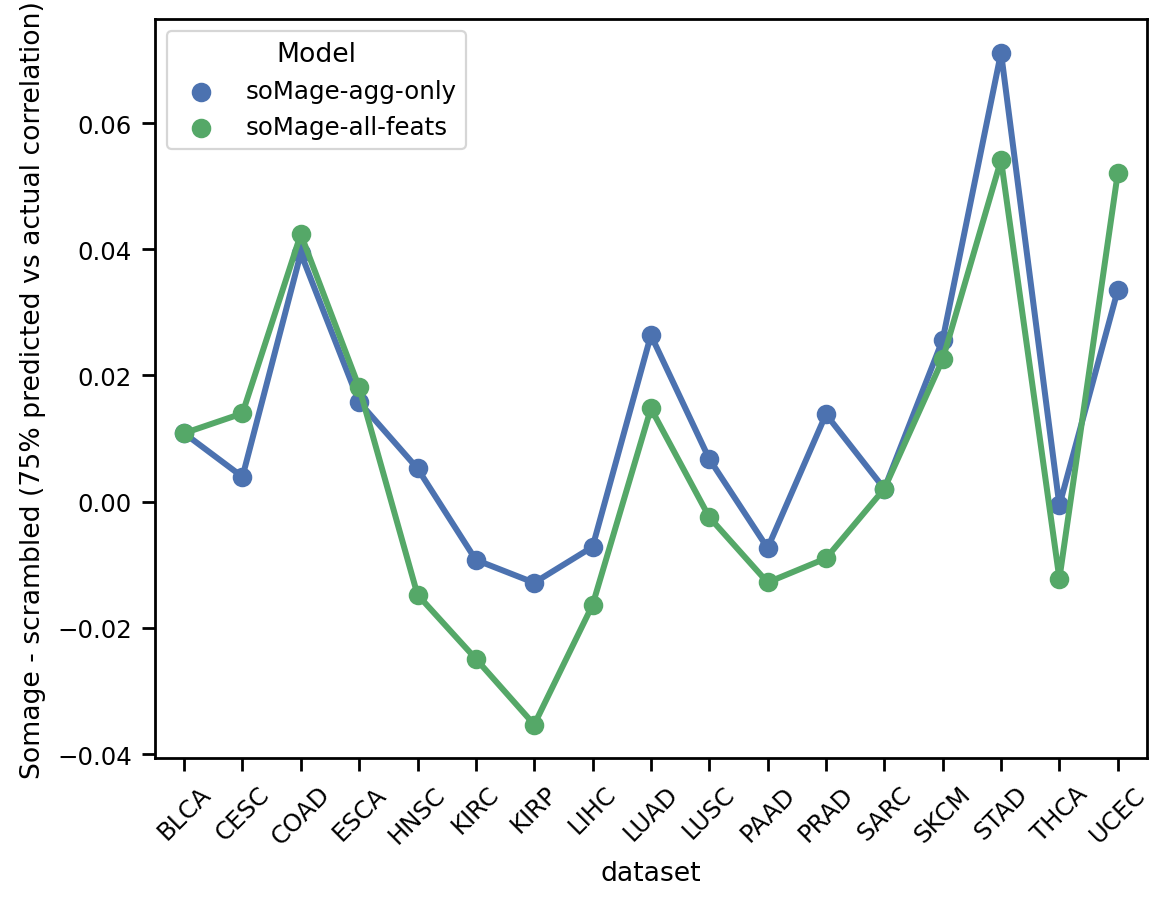

In [48]:
sns.pointplot(data = diff_df, y = '75%', x = 'dataset', hue = 'Model')
plt.ylabel('Somage - scrambled (75% predicted vs actual correlation)')
# angle x labels
_ = plt.xticks(rotation=45)

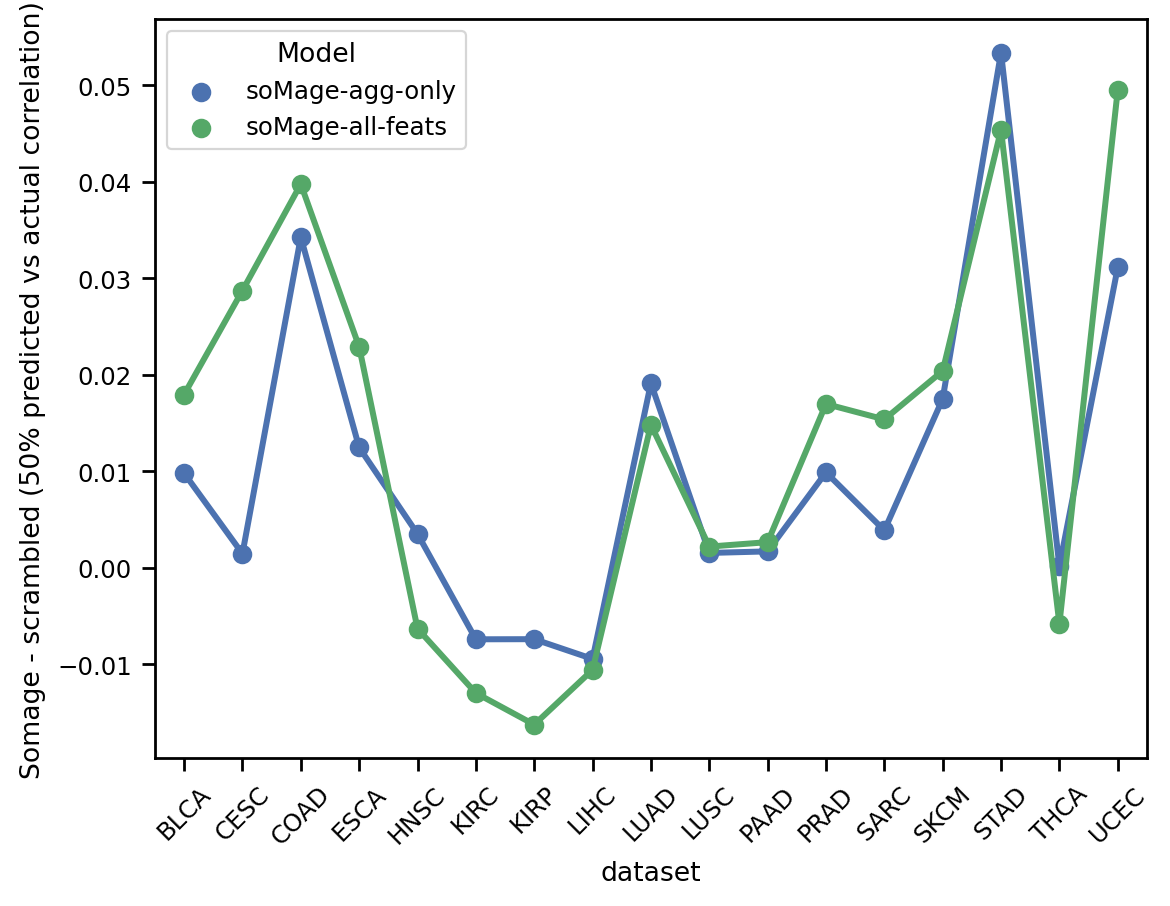

In [49]:
sns.pointplot(data = diff_df, y = '50%', x = 'dataset', hue = 'Model')
plt.ylabel('Somage - scrambled (50% predicted vs actual correlation)')
# angle x labels
_ = plt.xticks(rotation=45)

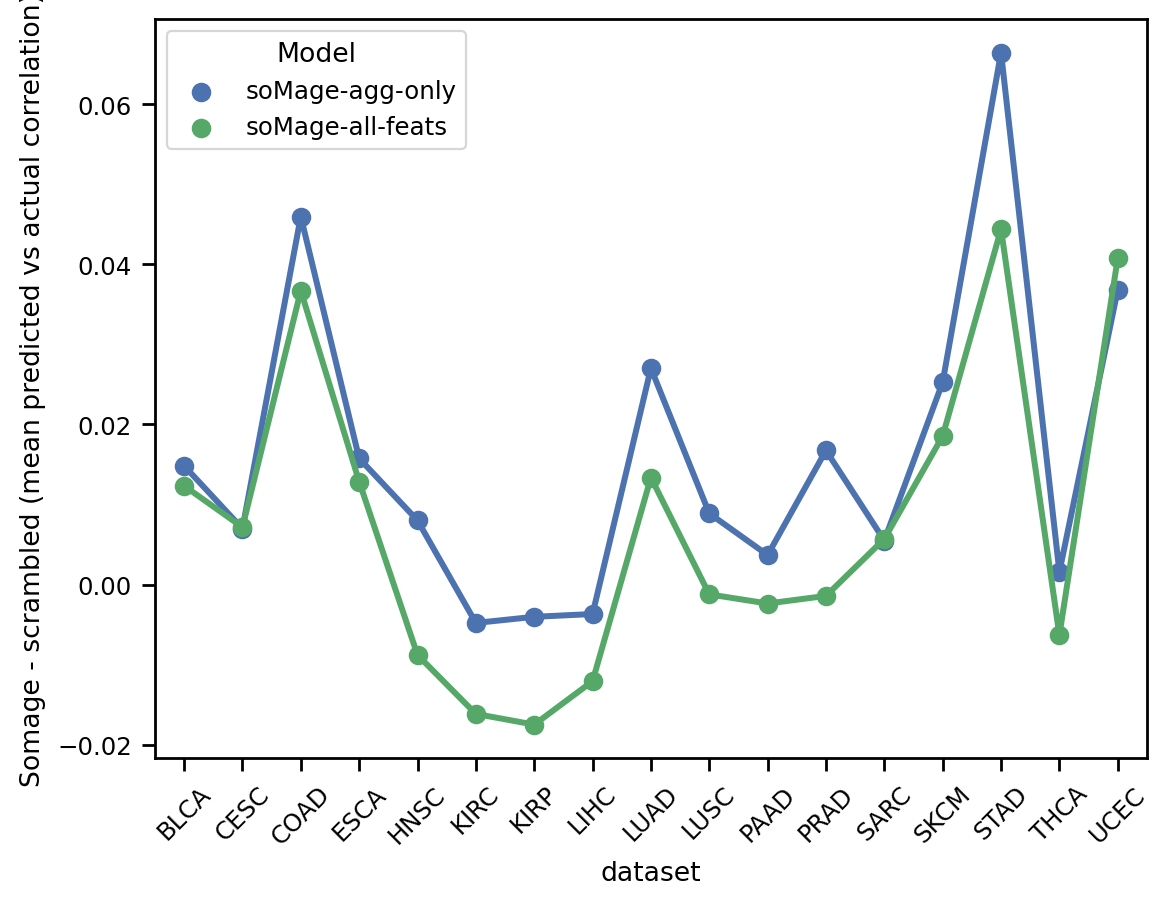

In [50]:
sns.pointplot(data = diff_df, y = 'mean', x = 'dataset', hue = 'Model')
plt.ylabel('Somage - scrambled (mean predicted vs actual correlation)')
# angle x labels
_ = plt.xticks(rotation=45)

<Axes: xlabel='AvP_methyl_pearson', ylabel='Count'>

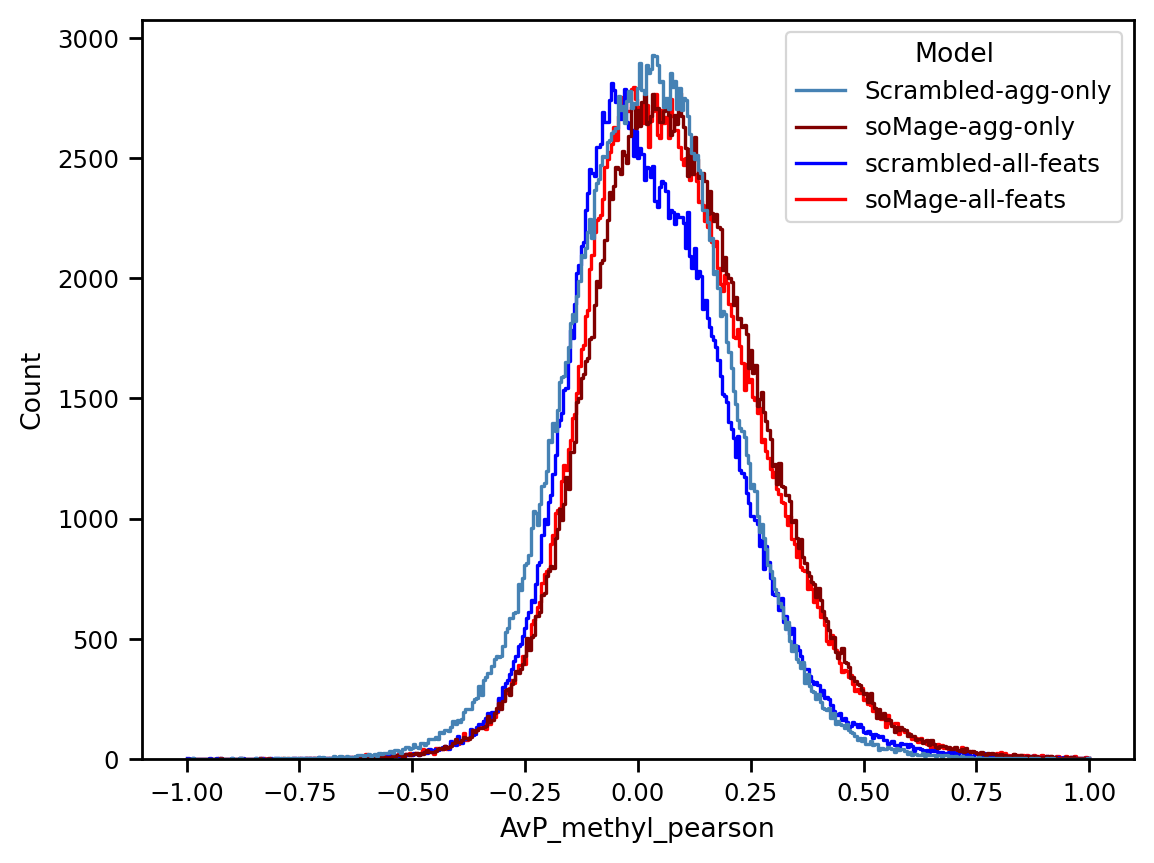

In [18]:
sns.set_context('paper')
sns.histplot(data = all_perf_df.query("dataset == 'STAD'").reset_index(drop=True), x = 'AvP_methyl_pearson', element="step", hue = 'Model', fill=False, stat='count',palette = ['steelblue',  'maroon','blue', 'red'])

<Axes: xlabel='AvP_methyl_pearson', ylabel='Count'>

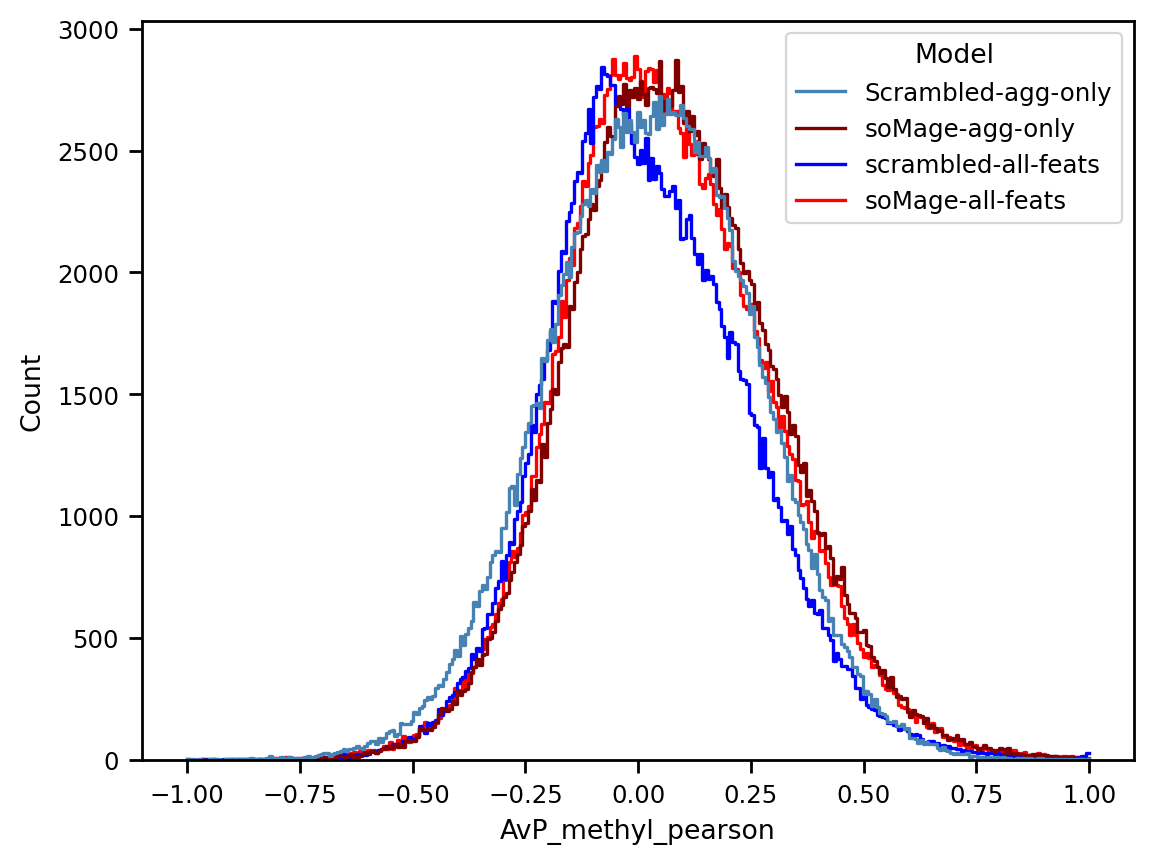

In [19]:
sns.set_context('paper')
sns.histplot(data = all_perf_df.query("dataset == 'COAD'").reset_index(drop=True), x = 'AvP_methyl_pearson', element="step", hue = 'Model', fill=False, stat='count',palette = ['steelblue',  'maroon','blue', 'red'])

#### FDR

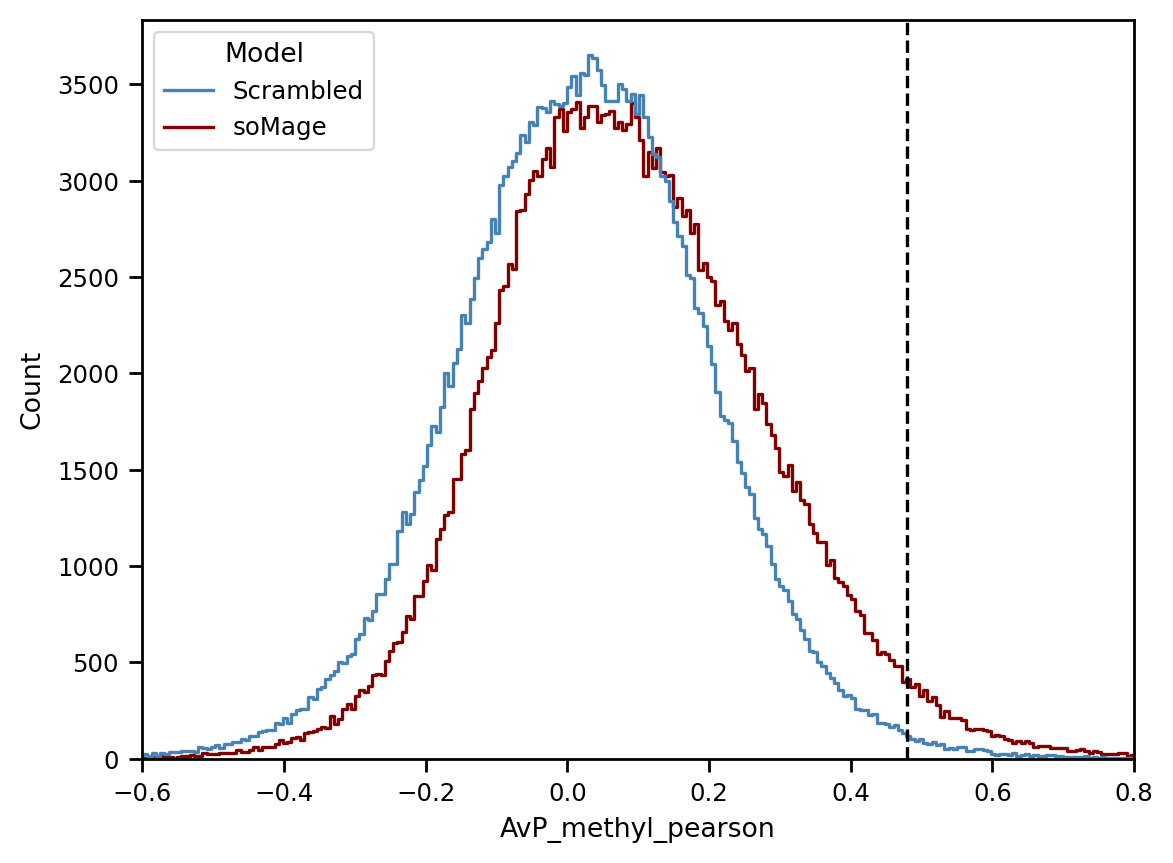

In [46]:
sns.set_context('paper')
sns.histplot(data = all_perf_df.query("dataset == 'STAD'").reset_index(drop=True), x = 'AvP_methyl_pearson', element="step", hue = 'Model', fill=False, stat='count',palette = ['steelblue', 'maroon'])
# draw vertical line at .48
plt.axvline(x=.48, color='black', linestyle='--')
plt.xlim(-0.6, .8)
plt.savefig('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure5/figure5C_methyl_pred_perf_STAD.svg', dpi=300, format = 'svg')

In [244]:
somage_scramble_tcga_dict[0].performance_by_dataset_df.query("dataset == 'STAD'")['cpg'].value_counts()

cg20701897    1
cg09243122    1
cg04241858    1
cg14003467    1
cg13165261    1
             ..
cg02788637    1
cg06655560    1
cg08529049    1
cg06002157    1
cg11903197    1
Name: cpg, Length: 262000, dtype: int64

In [48]:
somage_tcga_dict[0].performance_by_dataset_df.query("dataset == 'STAD' and AvP_methyl_pearson >= 0.48").shape[0]

7186

In [49]:
somage_tcga_dict[0].performance_by_dataset_df

,AvP_methyl_pearson,Pmethyl_v_Age_pearson_abs,train_AvP_methyl_pearson,train_Amethyl_v_Age_pearson_abs,dataset,cpg,model,Model
0,-0.190216,0.141932,0.433430,0.041841,HNSC,cg20701897,soMage-agg-only,soMage
1,0.195998,0.116538,0.327345,0.035197,HNSC,cg26991571,soMage-agg-only,soMage
2,0.095151,0.223876,0.355158,0.061438,HNSC,cg27022678,soMage-agg-only,soMage
3,0.329770,0.149263,0.312345,0.000264,HNSC,cg05941060,soMage-agg-only,soMage
4,-0.056760,0.244486,0.359766,0.025395,HNSC,cg20649716,soMage-agg-only,soMage
...,...,...,...,...,...,...,...,...
16995,0.143772,0.179554,0.329194,0.090944,ESCA,cg02753029,soMage-agg-only,soMage
16996,-0.202244,0.139662,0.342338,0.138413,ESCA,cg08858441,soMage-agg-only,soMage
16997,0.317202,0.156034,0.313324,0.030162,ESCA,cg14220055,soMage-agg-only,soMage
16998,0.015443,0.253770,0.255704,0.219675,ESCA,cg22521310,soMage-agg-only,soMage


In [39]:
# calculate a FDR cutoff 
# FDR at a given pearson correlation is the ratio of the number of scrambled beyond that number to the number of somage beyond that number
def fdr_cutoff(
    somage_perf: pd.DataFrame, 
    scrambled_perf: pd.DataFrame, 
    cutoff: float
    ):
    """
    Calculate the FDR given a cutoff of AvP_methyl_pearson
    """
    num_somage_past_cutoff = somage_perf.query("AvP_methyl_pearson >= @cutoff").shape[0]
    num_scrambled_past_cutoff = scrambled_perf.query("AvP_methyl_pearson >= @cutoff").shape[0]
    return num_scrambled_past_cutoff / (num_somage_past_cutoff + num_scrambled_past_cutoff)

# find where the FDR is less than 0.1
for cutoff in np.arange(.4, .8, 0.01):
    fdr = fdr_cutoff(
        somage_tcga_dict[0].performance_by_dataset_df.query("dataset == 'STAD'"),
        somage_scramble_tcga_dict[0].performance_by_dataset_df.query("dataset == 'STAD'"),
        cutoff
        )
    print(f"{cutoff:.2f} {fdr:.2f}")
    if fdr < 0.1:
        break



0.40 0.23
0.41 0.23
0.42 0.23
0.43 0.22
0.44 0.22
0.45 0.21
0.46 0.21
0.47 0.21
0.48 0.20
0.49 0.20
0.50 0.20
0.51 0.20
0.52 0.20
0.53 0.20
0.54 0.20
0.55 0.20
0.56 0.20
0.57 0.19
0.58 0.19
0.59 0.18
0.60 0.18
0.61 0.18
0.62 0.18
0.63 0.18
0.64 0.18
0.65 0.18
0.66 0.18
0.67 0.17
0.68 0.17
0.69 0.16
0.70 0.16
0.71 0.16
0.72 0.16
0.73 0.16
0.74 0.16
0.75 0.16
0.76 0.15
0.77 0.16
0.78 0.16
0.79 0.16


In [248]:
# calculate a FDR cutoff 
# FDR at a given pearson correlation is the ratio of the number of scrambled beyond that number to the number of somage beyond that number
def fdr_cutoff(
    somage_perf: pd.DataFrame, 
    scrambled_perf: pd.DataFrame, 
    cutoff: float
    ):
    """
    Calculate the FDR given a cutoff of AvP_methyl_pearson
    """
    num_somage_past_cutoff = somage_perf.query("AvP_methyl_pearson >= @cutoff").shape[0]
    num_scrambled_past_cutoff = scrambled_perf.query("AvP_methyl_pearson >= @cutoff").shape[0]
    return num_scrambled_past_cutoff / (num_somage_past_cutoff + num_scrambled_past_cutoff)

# find where the FDR is less than 0.1
for cutoff in np.arange(.4, .8, 0.01):
    fdr = fdr_cutoff(
        somage_tcga_dict[0].performance_by_dataset_df.query("dataset == 'LUAD'"),
        somage_scramble_tcga_dict[0].performance_by_dataset_df.query("dataset == 'LUAD'"),
        cutoff
        )
    print(f"{cutoff:.2f} {fdr:.2f}")
    if fdr < 0.1:
        break

0.40 0.30
0.41 0.30
0.42 0.29
0.43 0.28
0.44 0.28
0.45 0.27
0.46 0.27
0.47 0.27
0.48 0.27
0.49 0.26
0.50 0.26
0.51 0.26
0.52 0.26
0.53 0.26
0.54 0.26
0.55 0.26
0.56 0.26
0.57 0.26
0.58 0.26
0.59 0.26
0.60 0.25
0.61 0.25
0.62 0.25
0.63 0.26
0.64 0.25
0.65 0.25
0.66 0.25
0.67 0.25
0.68 0.25
0.69 0.25
0.70 0.25
0.71 0.26
0.72 0.26
0.73 0.26
0.74 0.26
0.75 0.26
0.76 0.28
0.77 0.28
0.78 0.28
0.79 0.29


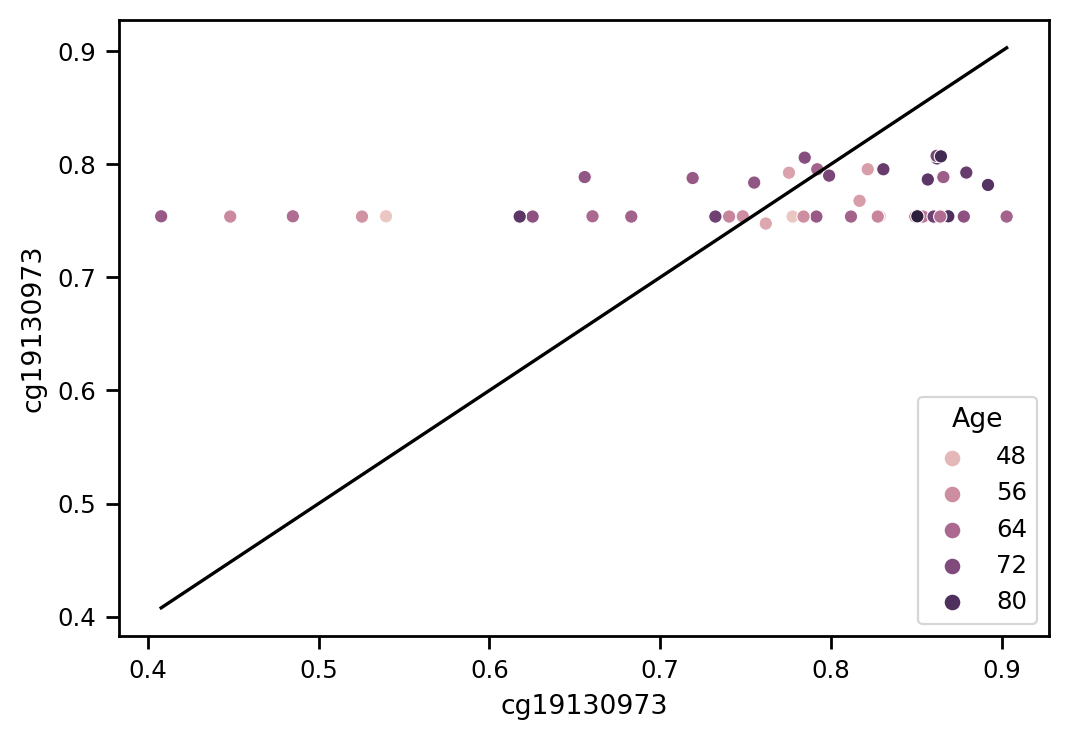

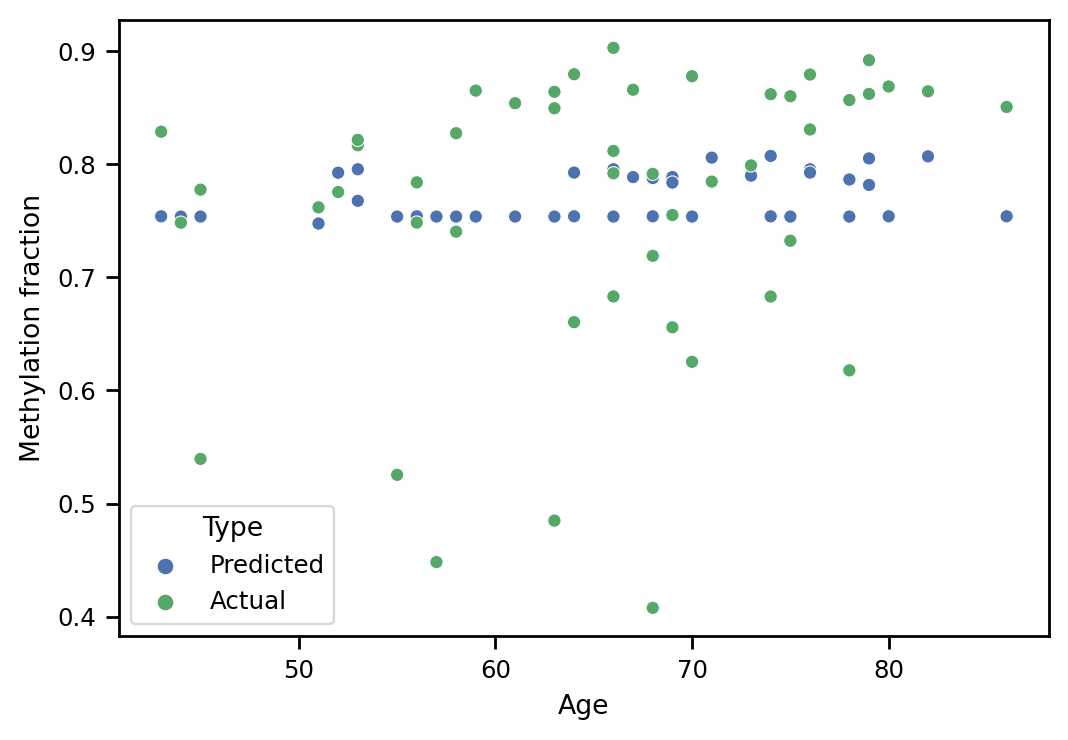

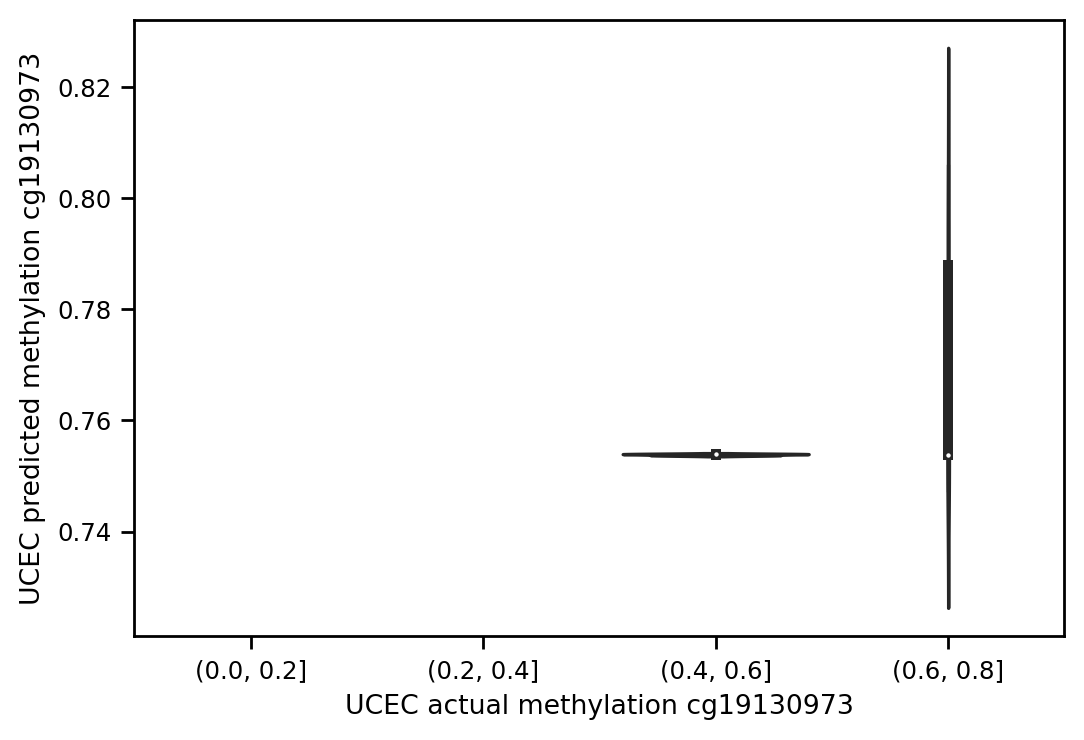

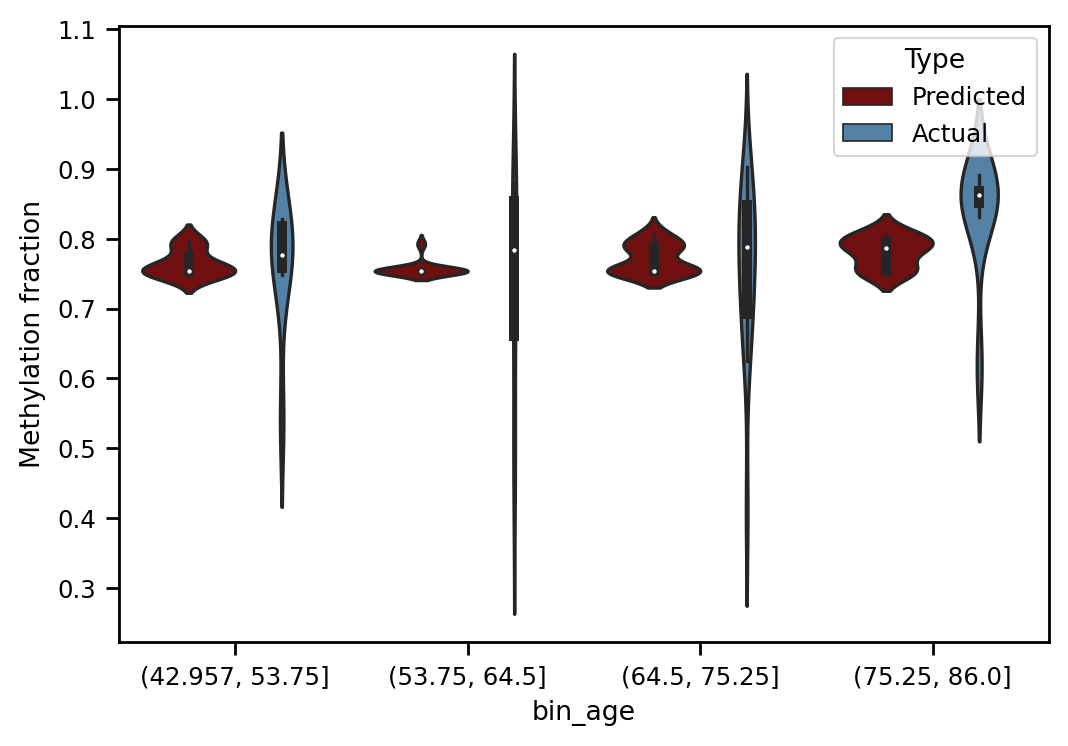

In [75]:
_ = somage_tcga_dict[0].plot_real_vs_predicted_methylation(
        cpg = "cg19130973",
        dataset = "STAD", 
        sample_set = "test",
        )

#### Feature importance

In [162]:
"""top_cpgs_list = somage_tcga_dict[cv_num].performance_by_dataset_df.query('dataset == @dataset and train_Amethyl_v_Age_pearson_abs > .2').sort_values(
    by = 'AvP_methyl_pearson', ascending = False
    ).head(top_cpgs)['cpg']"""
    
top_cpgs_list = somage_tcga_dict[cv_num].predicted_methyl_df.columns[:10000]

all_feat_imp_df_xgb, all_feat_imp_by_cat_df_xgb = somage_tcga_dict[cv_num].get_feat_importances(
        cpg_list = top_cpgs_list,
        dataset = '',
        importance_calculator = 'xgb',
        xgb_importance_type = 'gain',
        )

In [6]:
# get the CpGs with the highest average accuracy across all datasets
top_cpgs_list = somage_tcga_dict[cv_num].performance_by_dataset_df.groupby('cpg').mean().sort_values(
    'AvP_methyl_pearson', ascending=False
    ).index[:10000].tolist()
    
all_feat_imp_df_xgb_top, all_feat_imp_by_cat_df_xgb_top = somage_tcga_dict[cv_num].get_feat_importances(
        cpg_list = top_cpgs_list,
        dataset = '',
        importance_calculator = 'xgb',
        xgb_importance_type = 'gain',
        )

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


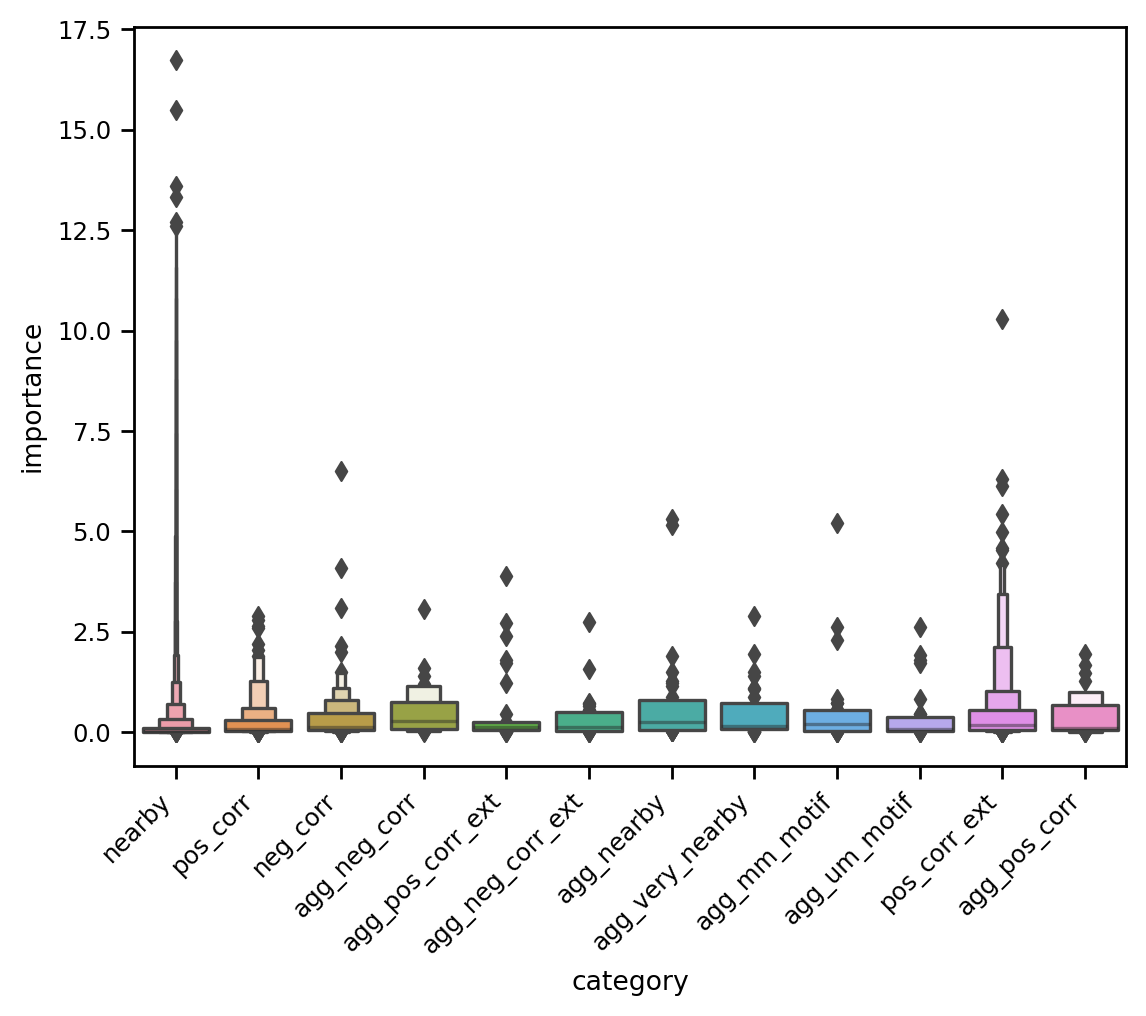

In [187]:
sns.boxenplot(data = all_feat_imp_df_xgb.query("importance > 0"), x = 'category', y = 'importance', 
# angle x ticks
_ = plt.xticks(rotation=45, ha='right')

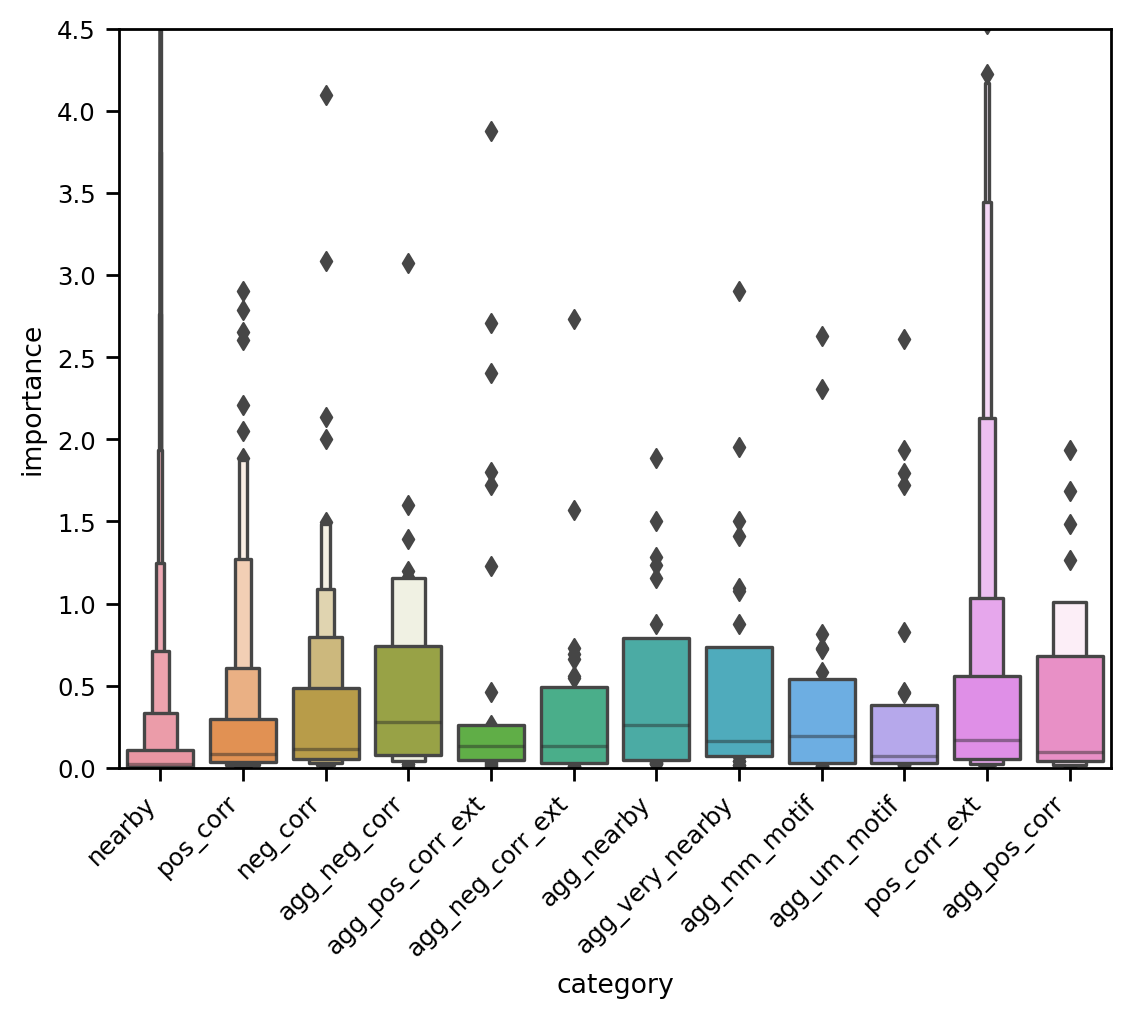

In [190]:
sns.boxenplot(data = all_feat_imp_df_xgb.query("importance > 0"), x = 'category', y = 'importance', showfliers=True)
plt.ylim(0, 4.5)
# angle x ticks
_ = plt.xticks(rotation=45, ha='right')

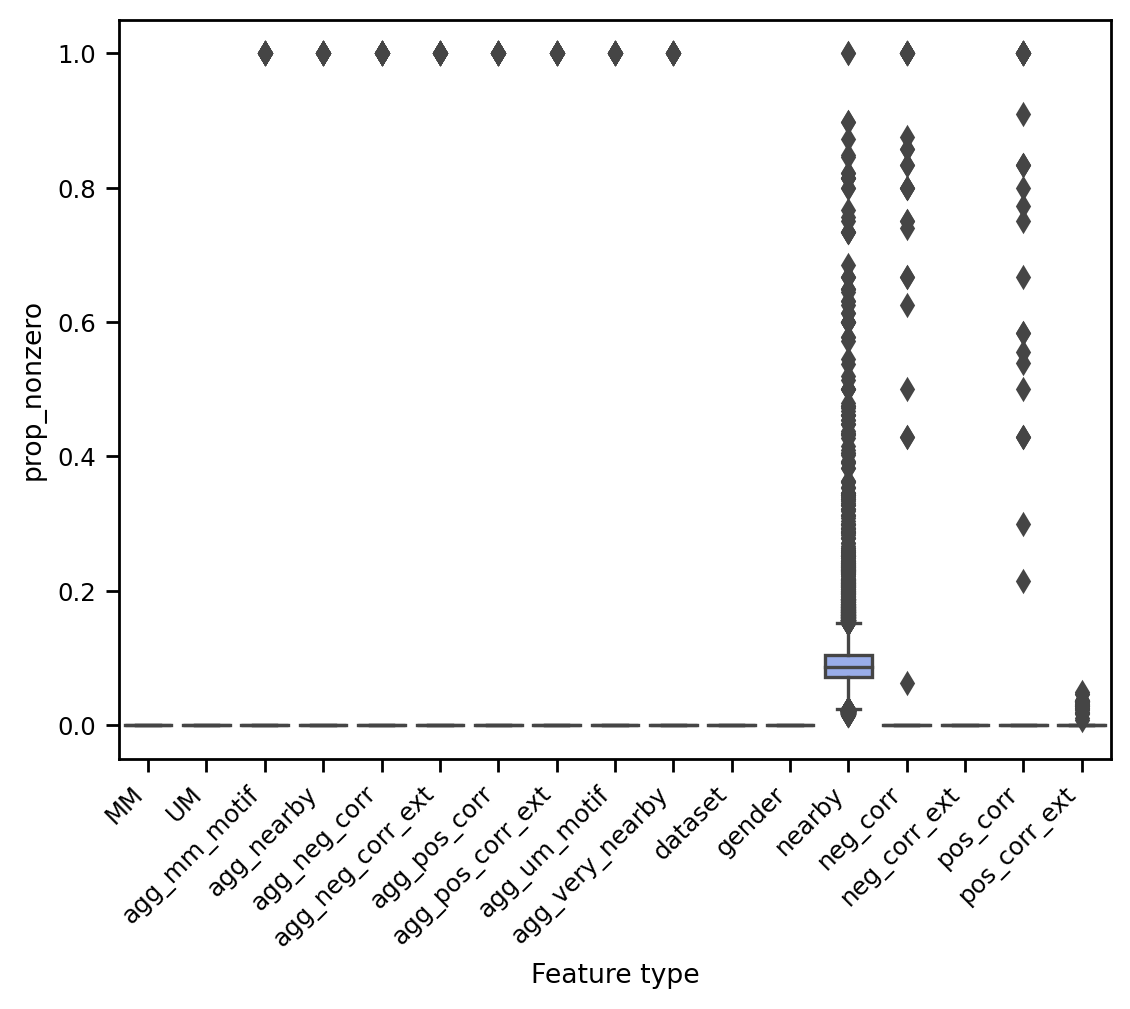

In [182]:
sns.boxplot(data = all_feat_imp_by_cat_df_xgb, x = 'Feature type', y = 'prop_nonzero', showfliers=True)
_ = plt.xticks(rotation=45, ha='right')


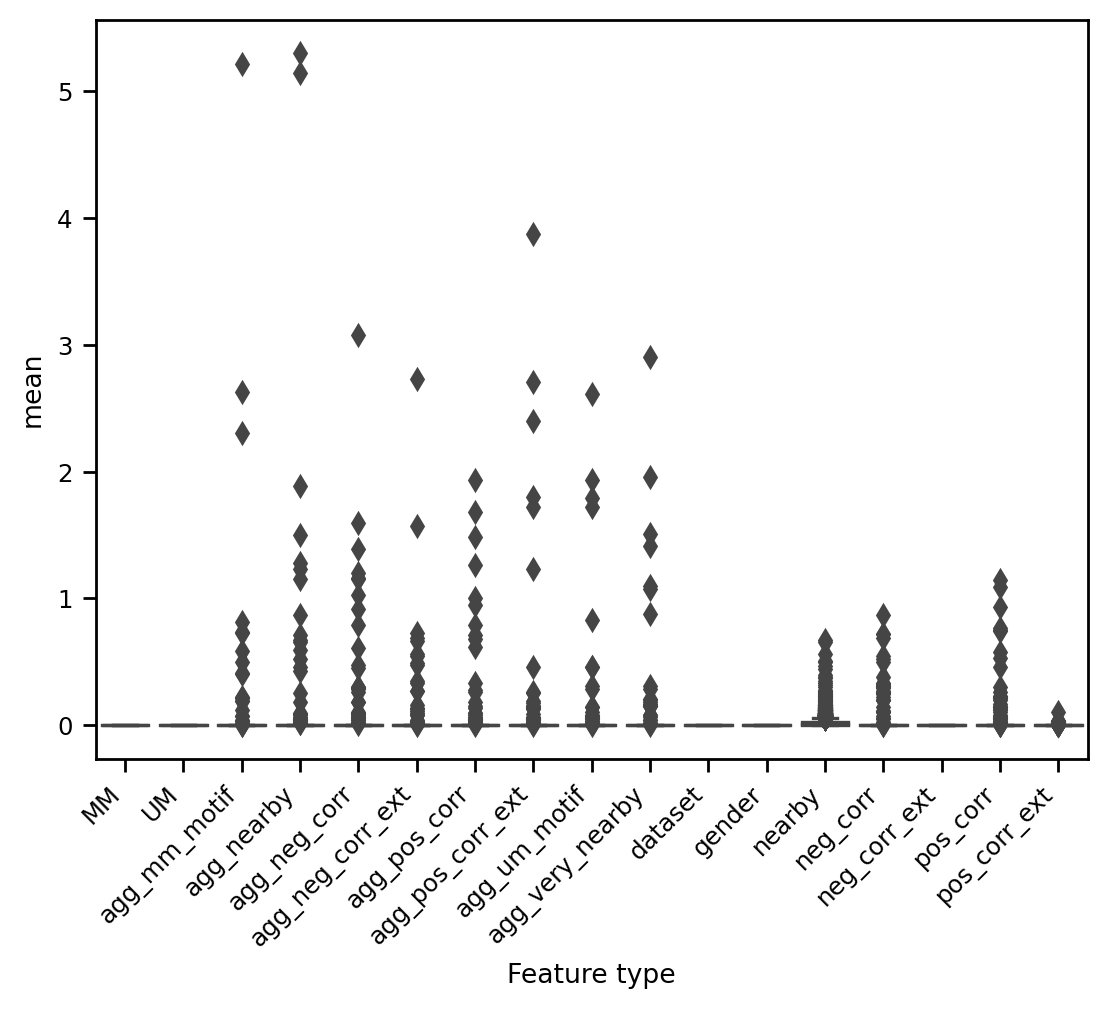

In [180]:
sns.boxplot(data = all_feat_imp_by_cat_df_xgb, x = 'Feature type', y = 'mean', showfliers=True)
_ = plt.xticks(rotation=45, ha='right')


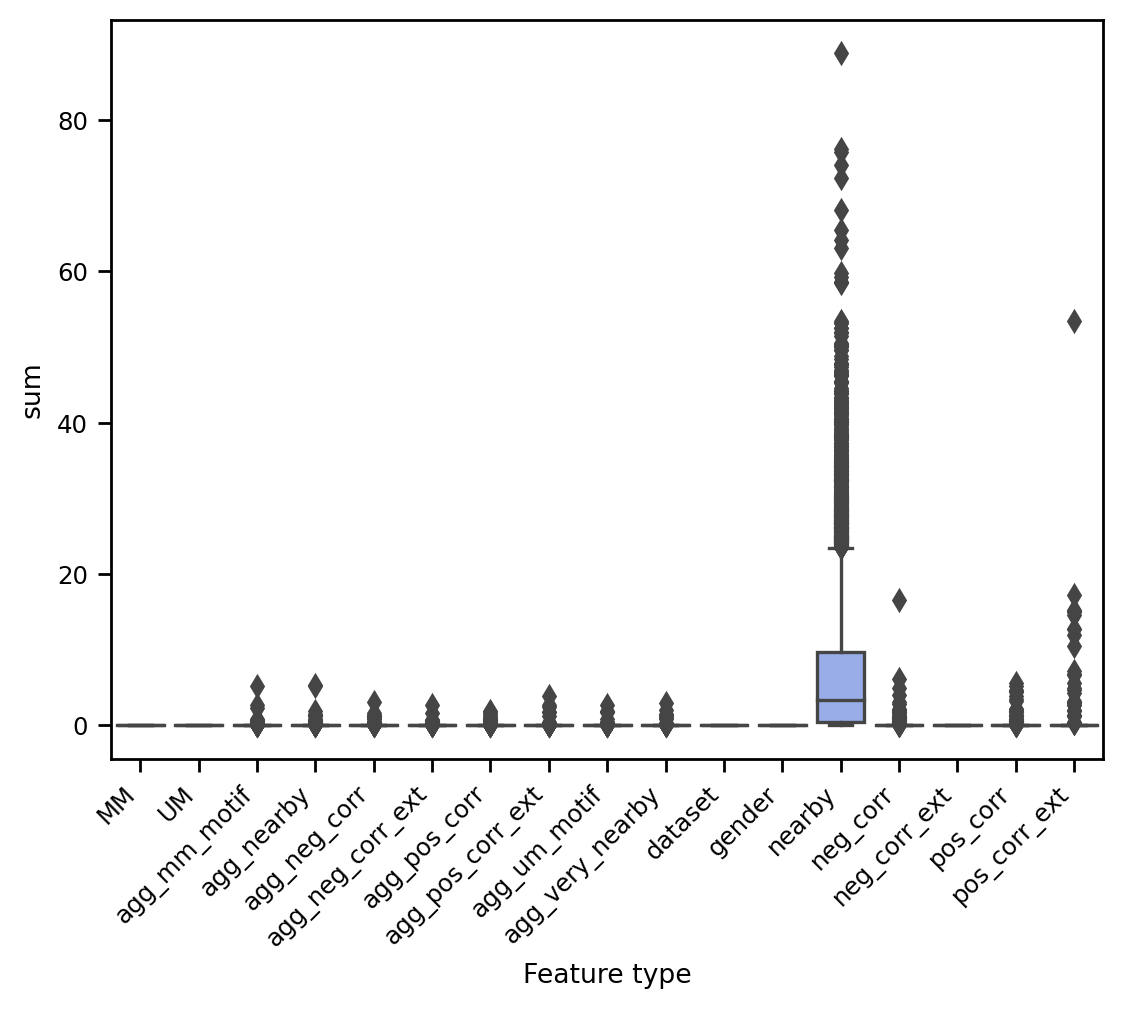

In [178]:
sns.boxplot(data = all_feat_imp_by_cat_df_xgb, x = 'Feature type', y = 'sum', showfliers=True)
_ = plt.xticks(rotation=45, ha='right')


#### Train epi-clock

In [ ]:
scan_results_df = somage_tcga_dict[cv_num].scan_for_best_clock_validation(
        datasets = somage_tcga_dict[cv_num].performance_by_dataset_df['dataset'].unique().tolist(),
        cpg_choosing_metrics = ['AvP_methyl_pearson', 'Pmethyl_v_Age_pearson_abs','train_AvP_methyl_pearson', 'train_Amethyl_v_Age_pearson_abs'],
        number_of_cpgs = [100, 500, 1000, 5000, 10000, 25000],
        model_types = ['xgboost'],#, 'elasticNet'],
        train_tissues = ['all', 'self'],
        training_methylation_types = ['actual', 'predicted'],
        use_gpu = False
        )

In [39]:
scan_results_df = pd.read_pickle('/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output/trained_clocks/epiClock_TCGA_cv0_predMethyl_scan_results_df.pkl')

In [90]:
scan_results_df.groupby(['cpg_choosing_metric', 'number_of_cpg','train_tissue', 'train_methylation_type' ])['pearson'].describe().sort_values(by=('mean'), ascending=False)

count  \
cpg_choosing_metric             number_of_cpg train_tissue train_methylation_type          
Pmethyl_v_Age_pearson_abs       5000          self         predicted                17.0   
AvP_methyl_pearson              5000          self         predicted                17.0   
Pmethyl_v_Age_pearson_abs       1000          self         actual                   17.0   
                                25000         all          actual                   17.0   
AvP_methyl_pearson              10000         all          actual                   17.0   
...                                                                                  ...   
train_Amethyl_v_Age_pearson_abs 500           all          actual                   17.0   
Pmethyl_v_Age_pearson_abs       10000         all          actual                   17.0   
train_Amethyl_v_Age_pearson_abs 100           self         actual                   17.0   
Pmethyl_v_Age_pearson_abs       5000          self         actual                   17.0   
train_AvP_methyl_pearson        10000         all          actual                   17.0   

                                                                                       mean  \
cpg_choosing_metric             number_of_cpg train_tissue train_methylation_type             
Pmethyl_v_Age_pearson_abs       5000          self         predicted               0.165132   
AvP_methyl_pearson              5000          self         predicted               0.135723   
Pmethyl_v_Age_pearson_abs       1000          self         actual                  0.132201   
                                25000         all          actual                  0.123654   
AvP_methyl_pearson              10000         all          actual                  0.115921   
...                                                                                     ...   
train_Amethyl_v_Age_pearson_abs 500           all          actual                 -0.065255   
Pmethyl_v_Age_pearson_abs       10000         all          actual                 -0.084264   
train_Amethyl_v_Age_pearson_abs 100           self         actual                 -0.085447   
Pmethyl_v_Age_pearson_abs       5000          self         actual                 -0.086908   
train_AvP_methyl_pearson        10000         all          actual                 -0.091815   

                                                                                        std  \
cpg_choosing_metric             number_of_cpg train_tissue train_methylation_type             
Pmethyl_v_Age_pearson_abs       5000          self         predicted               0.206503   
AvP_methyl_pearson              5000          self         predicted               0.228174   
Pmethyl_v_Age_pearson_abs       1000          self         actual                  0.238698   
                                25000         all          actual                  0.175921   
AvP_methyl_pearson              10000         all          actual                  0.137317   
...                                                                                     ...   
train_Amethyl_v_Age_pearson_abs 500           all          actual                  0.224279   
Pmethyl_v_Age_pearson_abs       10000         all          actual                  0.237624   
train_Amethyl_v_Age_pearson_abs 100           self         actual                  0.249308   
Pmethyl_v_Age_pearson_abs       5000          self         actual                  0.236963   
train_AvP_methyl_pearson        10000         all          actual                  0.156444   

                                                                                        min  \
cpg_choosing_metric             number_of_cpg train_tissue train_methylation_type             
Pmethyl_v_Age_pearson_abs       5000          self         predicted              -0.233263   
AvP_methyl_pearson              5000          self         predicted              -0.348354   
Pmethyl_v_Age_pearson_abs       10

<Axes: xlabel='dataset', ylabel='pearson'>

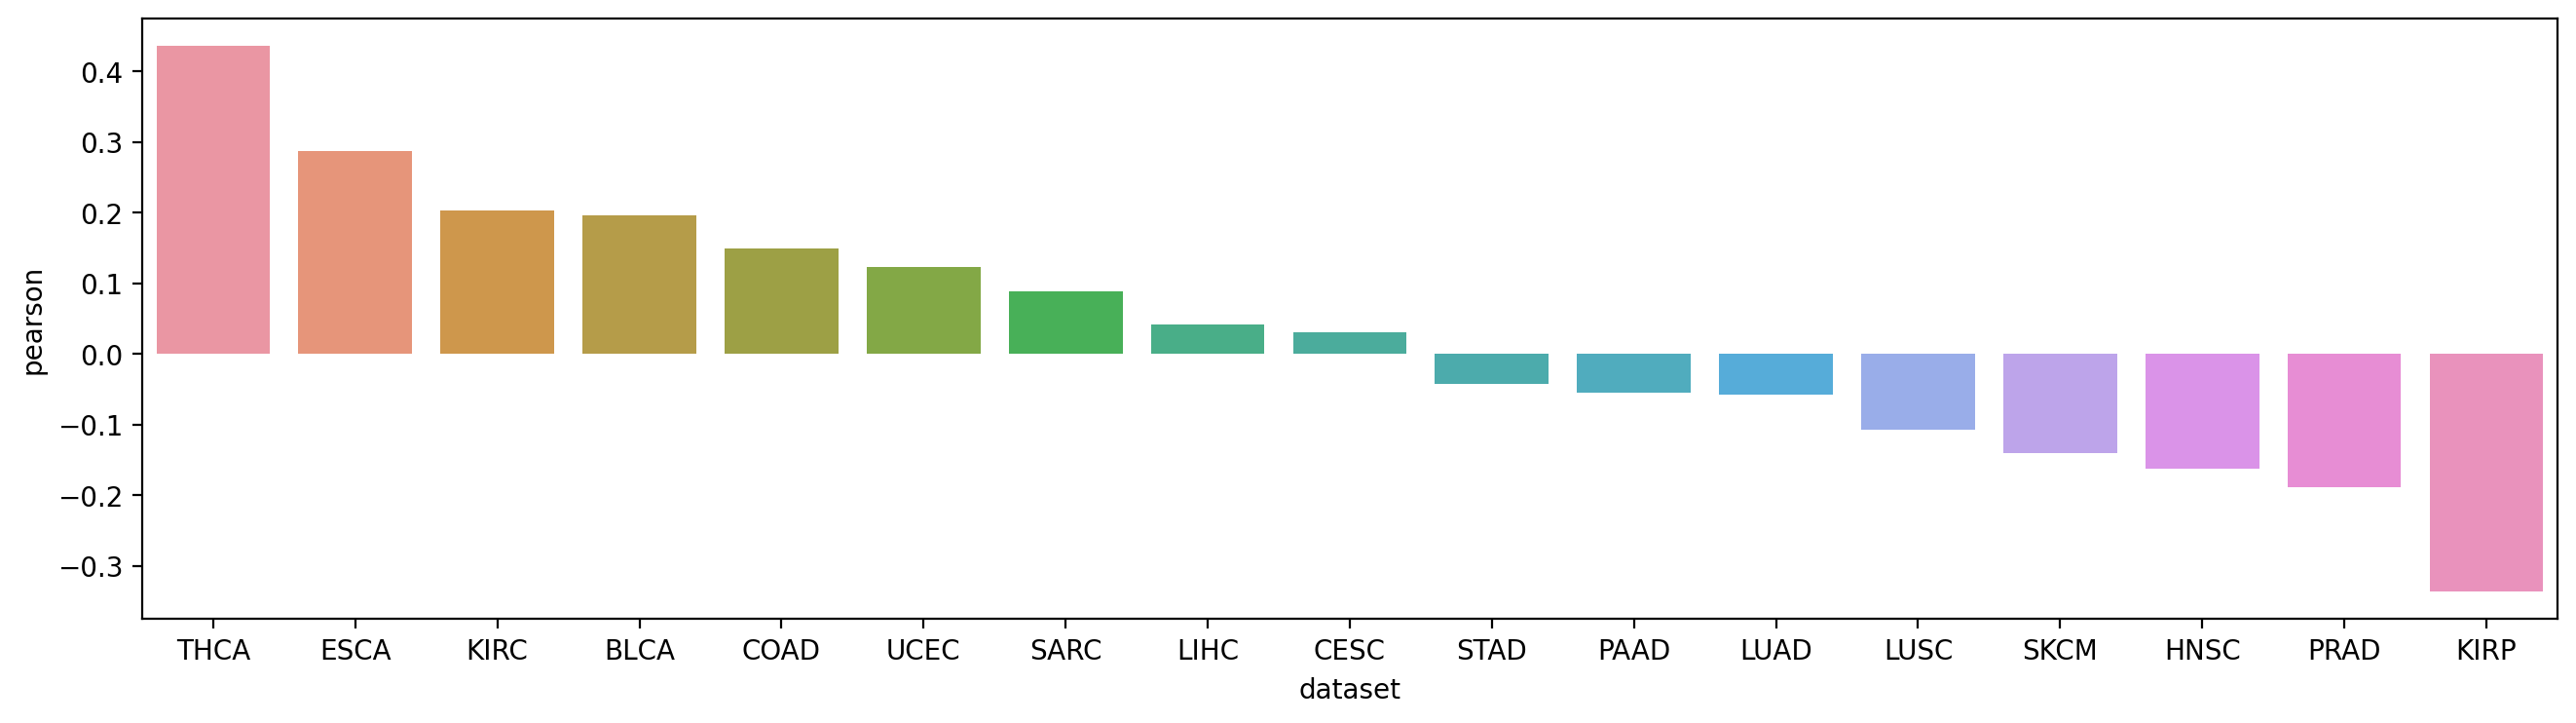

In [89]:
# median
fig, axes = plt.subplots(figsize = (16, 4))
sns.barplot(
    data = scan_results_df.query("cpg_choosing_metric == 'Pmethyl_v_Age_pearson_abs' and number_of_cpg == 1000 and train_tissue == 'self' and train_methylation_type == 'predicted'"),
    x = 'dataset', y = 'pearson', ax = axes
    )

<Axes: xlabel='dataset', ylabel='pearson'>

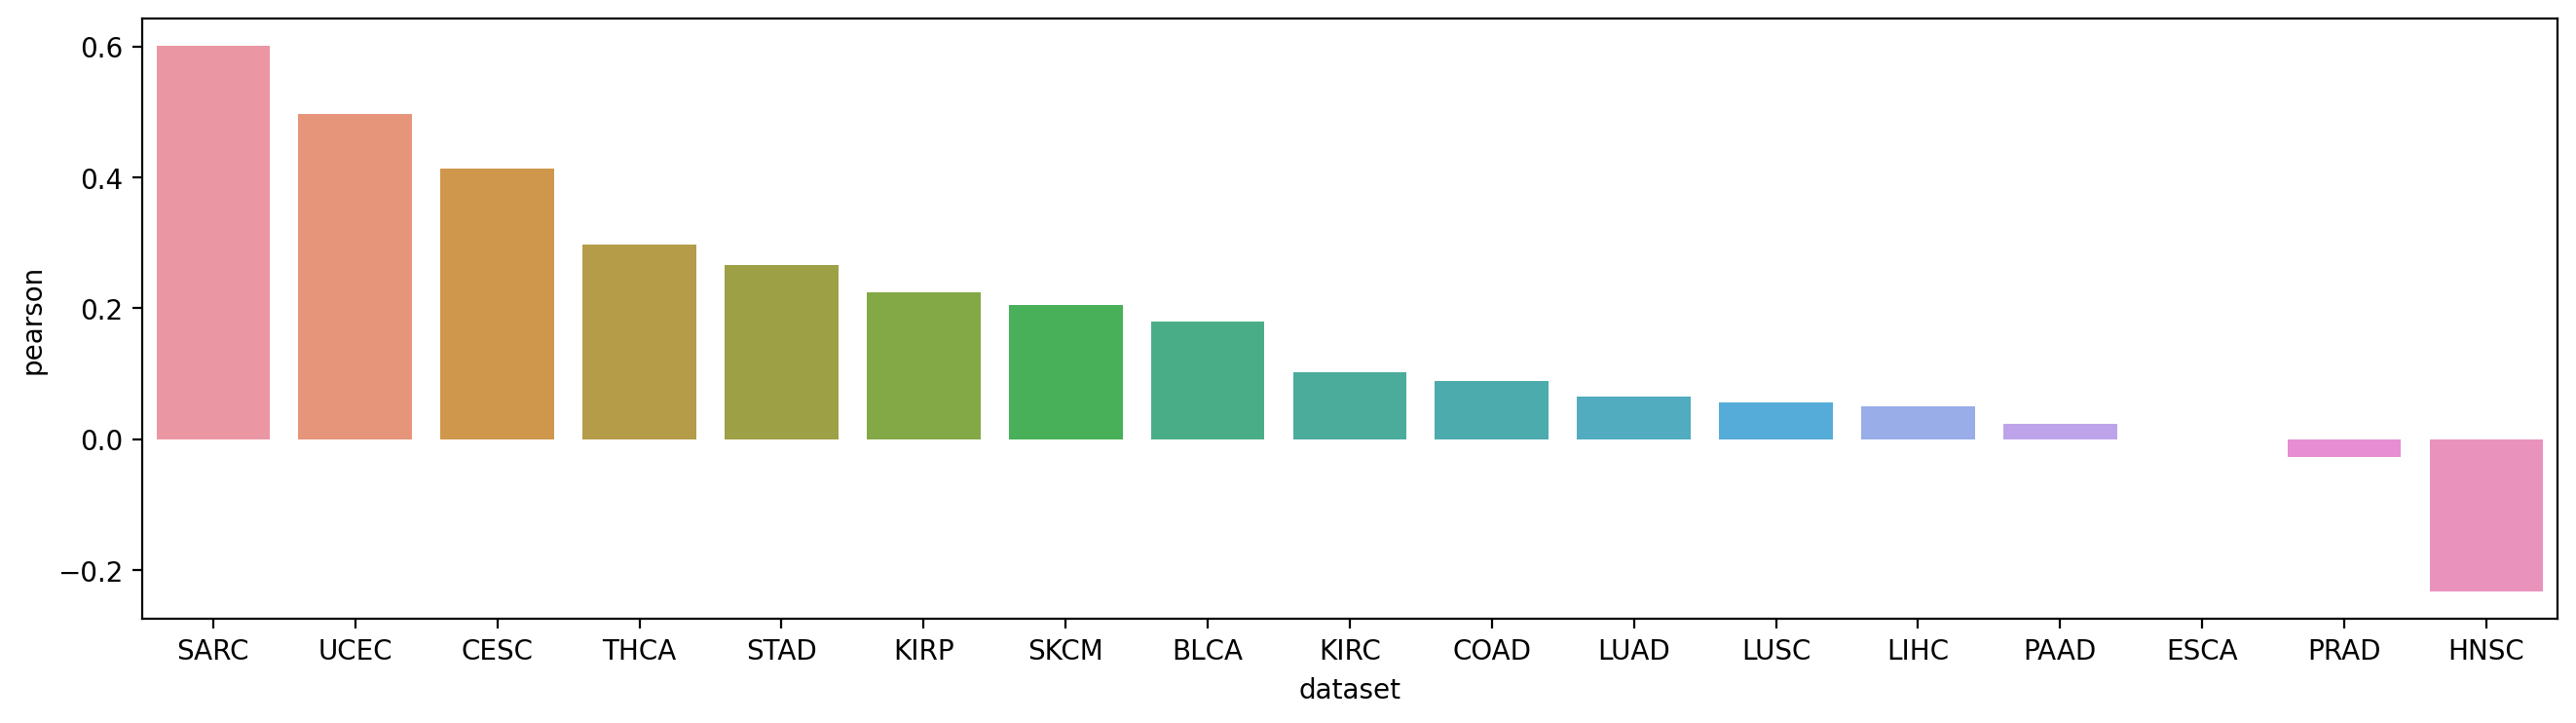

In [92]:
fig, axes = plt.subplots(figsize = (16, 4))
sns.barplot(
    data = scan_results_df.query("cpg_choosing_metric == 'Pmethyl_v_Age_pearson_abs' and number_of_cpg == 5000 and train_tissue == 'self' and train_methylation_type == 'predicted'"),
    x = 'dataset', y = 'pearson', ax = axes
    )

In [93]:
chosen_hyperparam_model_perfs = scan_results_df.query("cpg_choosing_metric == 'Pmethyl_v_Age_pearson_abs' and number_of_cpg == 5000 and train_tissue == 'self' and train_methylation_type == 'predicted'").reset_index(drop=True)

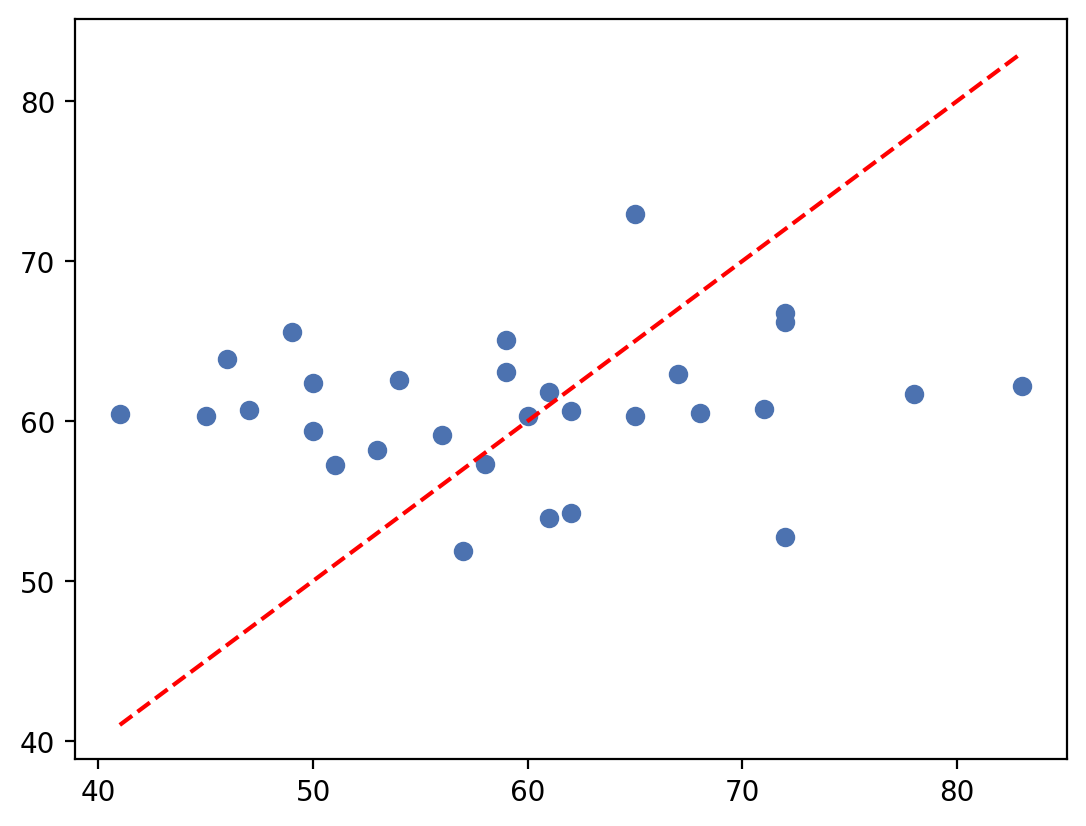

In [114]:
row = 8
plt.scatter(chosen_hyperparam_model_perfs.loc[row, 'y_validation'], chosen_hyperparam_model_perfs.loc[row, 'y_pred'])
# plot y =x based on min, max values of y_validation
plt.plot([chosen_hyperparam_model_perfs.loc[row, 'y_validation'].min(), chosen_hyperparam_model_perfs.loc[row, 'y_validation'].max()], 
            [chosen_hyperparam_model_perfs.loc[row, 'y_validation'].min(), chosen_hyperparam_model_perfs.loc[row, 'y_validation'].max()], 
            color='red', linestyle='--')

# ICGC Data

In [6]:
# qnorm 
icgc_mut_w_age_df, illumina_cpg_locs_df, icgc_methyl_age_df_t, icgc_matrix_qtl_dir, icgc_covariate_fn = get_data.read_icgc_data()

reading in data
Got mutations and metadata, reading methylation
Got methylation, transposing
Done


In [12]:
icgc_methyl_age_df_t.shape

(651, 326752)

In [11]:
icgc_mut_w_age_df

,case_submitter_id,chr,start,end,reference,alt,DNA_VAF,mutation,dataset,gender,dataset_r,gender_r,age_at_index
0,DO35009,16,10093626,10093626,C,A,0.136364,C>A,PACA,MALE,PACA,MALE,64
1,DO35009,10,6726330,6726330,G,C,0.275229,G>C,PACA,MALE,PACA,MALE,64
2,DO35009,10,107021254,107021254,C,A,0.432203,C>A,PACA,MALE,PACA,MALE,64
3,DO35009,1,26892465,26892465,A,G,0.176471,A>G,PACA,MALE,PACA,MALE,64
4,DO35009,8,96203326,96203326,A,T,0.275862,A>T,PACA,MALE,PACA,MALE,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919284,DO229096,20,23691266,23691266,G,C,0.469388,G>C,UTCA,FEMALE,UTCA,FEMALE,65
3919285,DO229096,12,128689264,128689264,A,T,0.285714,A>T,UTCA,FEMALE,UTCA,FEMALE,65
3919286,DO229096,12,128689264,128689264,A,T,0.329114,A>T,UTCA,FEMALE,UTCA,FEMALE,65
3919287,DO229096,X,122587198,122587198,C,T,0.250000,C>T,UTCA,FEMALE,UTCA,FEMALE,65


In [10]:
icgc_methyl_age_df_t['dataset'].value_counts()

PRAD    241
PACA    161
OV       92
PBCA     72
CLLE     47
PAEN     22
UTCA     16
Name: dataset, dtype: int64

In [8]:
icgc_mut_w_age_df['case_submitter_id'].nunique()


KeyboardInterrupt



# testing methyl pred

In [4]:
motif_occurence_df = pd.read_parquet(
        "/cellar/users/zkoch/methylation_and_mutation/data/methylation_motifs_weiWang/motif_occurences/motif_occurences_combined_15kb.parquet"
        )

In [21]:
mut_feat_tcga = mutation_features.mutationFeatures(
        all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
        all_methyl_age_df_t = all_methyl_age_df_t, out_dir = "./", 
        consortium = 'TCGA', dataset = '', cross_val_num = 0,
        matrix_qtl_dir = matrix_qtl_dir,
        covariate_fn = covariate_fn, motif_occurence_df = motif_occurence_df
    )

In [22]:
mut_feat_tcga.create_all_feat_mats(
    cpg_ids = ['cg20701897'], 
    aggregate = 'Both',
    num_correl_sites = 500, 
    max_meqtl_sites=0,
    nearby_window_size = 50000, 
    extend_amount = 500 
    )

Finished 0 of 1


In [6]:
# read in a mutation features store 
mut_store_dict = pd.read_pickle("/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output/TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_0startTopCpGs_500extendAmount_0crossValNum/TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_0startTopCpGs_500extendAmount_0crossValNum.features.pkl")

In [19]:
df_from_job = pd.DataFrame(mut_store_dict['feat_mats']['cg20701897'].todense(), columns = mut_store_dict['feat_names']['cg20701897'])

In [23]:
df_from_notebook = pd.DataFrame(mut_feat_tcga.mutation_features_store['feat_mats']['cg20701897'].todense(), columns = mut_feat_tcga.mutation_features_store['feat_names']['cg20701897'])

In [24]:
df_from_notebook[df_from_notebook.columns[df_from_notebook.columns.str.contains('agg')]].sum()

agg_pos_corr+          6.630005
agg_neg_corr+          4.779663
agg_pos_corr_ext+    524.618042
agg_neg_corr_ext+    452.069489
agg_nearby+          783.176697
agg_very_nearby+     116.592194
agg_mm_motif+          5.610016
agg_um_motif+          0.000000
dtype: float32

In [58]:
df.sum()

nearby+2:179561894      0.209961
nearby+2:179563573      0.059998
nearby+2:179563588      0.099976
nearby+2:179563606      0.370117
nearby+2:179563636      0.090027
                         ...    
dataset+THCA          488.000000
dataset+THYM          121.000000
dataset+UCEC          398.000000
dataset+UCS            57.000000
dataset+UVM            80.000000
Length: 3287, dtype: float32

In [53]:
df = pd.DataFrame(mut_feat_tcga.mutation_features_store['feat_mats']['cg20701897'].todense(), columns = mut_feat_tcga.mutation_features_store['feat_names']['cg20701897'])

In [15]:
methyl_pred = methylation_pred.methylationPrediction(
    mut_feat_store_fns = ["/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output/TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_0startTopCpGs_500extendAmount_0crossValNum/TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_0startTopCpGs_500extendAmount_0crossValNum.features.pkl"],
    model_type = "xgboost",
    baseline = "none",
    agg_only = True,
    scale_counts_within_dataset = False,
    predict_with_random_feat = -1,
    illumina_cpg_locs_df = illumina_cpg_locs_df,
    all_methyl_age_df_t = all_methyl_age_df_t,
    use_gpu = False
    )

Done reading /cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output/TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_0startTopCpGs_500extendAmount_0crossValNum/TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_0startTopCpGs_500extendAmount_0crossValNum.features.pkl


In [42]:
methyl_pred.train_all_models(just_one = False)
#methyl_pred.apply_all_models(just_one = True)
#methyl_pred.calc_performance_by_dataset()

agg feature sums
agg_pos_corr+        0.0
agg_neg_corr+        0.0
agg_pos_corr_ext+    0.0
agg_neg_corr_ext+    0.0
agg_nearby+          0.0
agg_very_nearby+     0.0
agg_mm_motif+        0.0
agg_um_motif+        0.0
dtype: float32
OUTER: done training 0 CpGs of 1000
agg feature sums
agg_pos_corr+        0.0
agg_neg_corr+        0.0
agg_pos_corr_ext+    0.0
agg_neg_corr_ext+    0.0
agg_nearby+          0.0
agg_very_nearby+     0.0
agg_mm_motif+        0.0
agg_um_motif+        0.0
dtype: float32
agg feature sums
agg_pos_corr+        0.0
agg_neg_corr+        0.0
agg_pos_corr_ext+    0.0
agg_neg_corr_ext+    0.0
agg_nearby+          0.0
agg_very_nearby+     0.0
agg_mm_motif+        0.0
agg_um_motif+        0.0
dtype: float32
agg feature sums
agg_pos_corr+        0.0
agg_neg_corr+        0.0
agg_pos_corr_ext+    0.0
agg_neg_corr_ext+    0.0
agg_nearby+          0.0
agg_very_nearby+     0.0
agg_mm_motif+        0.0
agg_um_motif+        0.0
dtype: float32
agg feature sums
agg_pos_corr+      

In [23]:
methyl_pred_scramble = methylation_pred.methylationPrediction(
    mut_feat_store_fns = ["/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output/TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_0startTopCpGs_500extendAmount_0crossValNum/TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_0startTopCpGs_500extendAmount_0crossValNum.features.pkl"],
    model_type = "xgboost",
    baseline = "scramble",
    agg_only = True,
    scale_counts_within_dataset = False,
    predict_with_random_feat = -1,
    illumina_cpg_locs_df = illumina_cpg_locs_df,
    all_methyl_age_df_t = all_methyl_age_df_t,
    use_gpu = False
    )

Done reading /cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output/TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_0startTopCpGs_500extendAmount_0crossValNum/TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_0startTopCpGs_500extendAmount_0crossValNum.features.pkl


In [39]:
methyl_pred_scramble.train_all_models(just_one = True)
#methyl_pred_scramble.apply_all_models(just_one = True)
#methyl_pred_scramble.calc_performance_by_dataset()

scrambling
before scrambling
3254    3149.0
3253    2928.0
3257     519.0
3276     409.0
3282     392.0
         ...  
1098       0.0
1099       0.0
1100       0.0
1101       0.0
1643       0.0
Length: 3287, dtype: float32
3253    gender+FEMALE
3254      gender+MALE
3255      dataset+ACC
3256     dataset+BLCA
3257     dataset+BRCA
3258     dataset+CESC
3259     dataset+CHOL
3260     dataset+COAD
3261     dataset+DLBC
3262     dataset+ESCA
3263      dataset+GBM
3264     dataset+HNSC
3265     dataset+KICH
3266     dataset+KIRC
3267     dataset+KIRP
3268     dataset+LAML
3269     dataset+LIHC
3270     dataset+LUAD
3271     dataset+LUSC
3272     dataset+MESO
3273       dataset+OV
3274     dataset+PAAD
3275     dataset+PCPG
3276     dataset+PRAD
3277     dataset+READ
3278     dataset+SARC
3279     dataset+SKCM
3280     dataset+STAD
3281     dataset+TGCT
3282     dataset+THCA
3283     dataset+THYM
3284     dataset+UCEC
3285      dataset+UCS
3286      dataset+UVM
dtype: object
3254    3149.0


,AvP_methyl_pearson,Pmethyl_v_Age_pearson_abs,train_AvP_methyl_pearson,train_Amethyl_v_Age_pearson_abs,dataset,cpg
0,-0.330673,0.061125,0.028316,0.041841,HNSC,cg20701897
1,-0.044626,0.211605,0.048890,0.156828,THCA,cg20701897
2,NaN,NaN,NaN,0.058500,PRAD,cg20701897
3,-0.019248,0.317847,0.073489,0.040737,SKCM,cg20701897
4,0.191358,0.053916,0.078447,0.117626,LUAD,cg20701897
5,NaN,NaN,NaN,0.115320,UCEC,cg20701897
6,-0.357796,0.225030,0.014127,0.038505,BLCA,cg20701897
7,-0.353059,0.101876,0.009143,0.011966,STAD,cg20701897
8,-0.307724,0.187289,0.024973,0.200761,LIHC,cg20701897
9,0.157638,0.016516,0.081086,0.100244,LUSC,cg20701897


# Feature importances

In [32]:
# for each of the best predicted CpGs 
cv_num = 0
top_cpgs = 50
dataset = 'UCEC'

top_cpgs_list = somage_tcga_dict[cv_num].performance_by_dataset_df.query('dataset == @dataset').sort_values(
    by = 'AvP_methyl_spearman', ascending = False
    ).head(top_cpgs)['cpg']

all_feat_imp_dfs = []
all_feat_imp_by_cat_dfs = []
for cpg in top_cpgs_list:
    # get the model and feature names
    model, feat_names, train_mat, test_mat = (
        somage_tcga_dict[cv_num]
        .get_model_feat_names_train_test(cpg, dataset = dataset)
        )
    feat_imp_df, feat_imp_by_cat_df = somage_tcga_dict[cv_num].get_one_cpg_feat_score_by_cat(
        model, feat_names, train_mat, test_mat, 
        importance_calculator = 'shap', importance_type = "gain"
        )
    feat_imp_df['cpg'] = cpg
    feat_imp_by_cat_df['cpg'] = cpg
    all_feat_imp_dfs.append(feat_imp_df)
    all_feat_imp_by_cat_dfs.append(feat_imp_by_cat_df)
    
all_feat_imp_df = pd.concat(all_feat_imp_dfs).drop_duplicates()
all_feat_imp_by_cat_df = pd.concat(all_feat_imp_by_cat_dfs).drop_duplicates()
all_feat_imp_by_cat_df.rename(columns = {'category': 'Feature type'}, inplace = True)

all_feat_imp_by_cat_df['Feature type'] = all_feat_imp_by_cat_df['Feature type'].map({
    'Nearby locus': 'Specific loci (<50kb distance)',
    'dataset':'Tissue type',
    'matrixqtl_neg_beta': 'Aggregated - somatic-meQTLS', 
    'matrixqtl_pos_beta': 'Aggregated + somatic-meQTLS', 
    'matrixqtl_neg_beta_close': 'Aggregated - somatic-meQTLS (<50kb distance)', 
    'matrixqtl_pos_beta_close': 'Aggregated + somatic-meQTLS (<50kb distance)', 
    'matrixqtl_neg_beta_close_ext': 'Aggregated - somatic-meQTLS (<50kb distance, extended', 
    'matrixqtl_pos_beta_close_ext': 'Aggregated + somatic-meQTLS (<50kb distance, extended)', 
    'nearby': 'Aggregated nearby loci (<50kb distance)',
    'neg_corr': 'Aggregated negatively correlated CpGs',
    'pos_corr': 'Aggregated positively correlated CpGs',
    'pos_corr_ext': 'Aggregated positively correlated CpGs (extended)',
    'neg_corr_ext': 'Aggregated negatively correlated CpGs (extended)',
    'specific_corr_ext': 'Specific correlated CpG (extended)',
    'specific_nested': 'Specific nested feature',
    'specific_tesselated': 'Specific tesselated feature',
    'very_nearby': 'Specific loci (<1kb distance)',
    'specific_neg_beta_close_ext': 'Specific - somatic-meQTLS (<50kb distance, extended)',
    'specific_neg_beta_ext': 'Specific - somatic-meQTLS (extended)',
    'specific_pos_beta_close_ext': 'Specific + somatic-meQTLS (<50kb distance, extended)',
    'specific_pos_beta_ext': 'Specific + somatic-meQTLS (extended)',
})


 98%|===================| 1485/1523 [00:11<00:00]        

# Co-localization soMage

### Development

In [ ]:
motif_occurence_df = pd.read_parquet(
        "/cellar/users/zkoch/methylation_and_mutation/data/methylation_motifs_weiWang/motif_occurences/motif_occurences_combined_15kb.parquet"
        )
mut_feat_icgc = mutation_features.mutationFeatures(
        all_mut_w_age_df = icgc_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
        all_methyl_age_df_t = icgc_methyl_age_df_t, out_dir = "./", 
        consortium = 'ICGC', dataset = '', cross_val_num = 0,
        matrix_qtl_dir = icgc_matrix_qtl_dir,
        covariate_fn = icgc_covariate_fn, motif_occurence_df = motif_occurence_df
    )

In [10]:
mut_feat_params = {
    'aggregate': 'Both',
    'num_correl_sites': 500,
    'max_meqtl_sites': 0,
    'nearby_window_size': 50000,
    'extend_amount': 500
}

mut_feat_icgc.create_all_feat_mats(
    cpg_ids = icgc_methyl_age_df_t.columns[5:10].tolist(), 
    aggregate = mut_feat_params['aggregate'],
    num_correl_sites = mut_feat_params['num_correl_sites'], 
    max_meqtl_sites=mut_feat_params['max_meqtl_sites'],
    nearby_window_size = mut_feat_params['nearby_window_size'], 
    extend_amount = mut_feat_params['extend_amount'] 
    )

Finished 0 of 5


In [71]:
methyl_pred = methylation_pred.methylationPrediction(
                mut_feat_store = mut_feat_icgc.mutation_features_store,
                #mut_feat_store_fns = mut_feat_store_fns,
                model_type = "xgboost",
                baseline = "none",
                agg_only = True,
                scale_counts_within_dataset = True,
                predict_with_random_feat = 2,
                illumina_cpg_locs_df = illumina_cpg_locs_df,
                )
methyl_pred.train_all_models()
methyl_pred.apply_all_models()
methyl_pred.save_models_and_preds(out_dir = "/cellar/users/zkoch/methylation_and_mutation/test_out")

['cg00000289', 'cg00000622', 'cg00000165', 'cg00000292']
INNER: done training 0 CpGs of 3
OUTER: done training 0 CpGs of 5
['cg00000622', 'cg00000289', 'cg00000109', 'cg00000292']
INNER: done training 0 CpGs of 3
['cg00000622', 'cg00000109', 'cg00000165', 'cg00000292']
INNER: done training 0 CpGs of 3
['cg00000622', 'cg00000109', 'cg00000165', 'cg00000289']
INNER: done training 0 CpGs of 3
['cg00000289', 'cg00000109', 'cg00000165', 'cg00000292']
INNER: done training 0 CpGs of 3
Predicted methylation for 0 CpGs of 15
Predicted methylation for 10 CpGs of 15
wrote out trained models and predictions to /cellar/users/zkoch/methylation_and_mutation/test_out


### Results

In [4]:
mut_feat_tcga_coloc_dict = {}
somage_tcga_coloc_dict = {}

# for each cv iteration
for cv_num in [0]:
    # create a mutation features object
    mut_feat_tcga = mutation_features.mutationFeatures(
        all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
        all_methyl_age_df_t = all_methyl_age_df_t, out_dir = "./", 
        consortium = 'TCGA', dataset = '', cross_val_num = cv_num,
        matrix_qtl_dir = matrix_qtl_dir,
        covariate_fn = covariate_fn, motif_occurence_df = pd.DataFrame()
    )
    # add to dictionary
    mut_feat_tcga_coloc_dict[cv_num] = mut_feat_tcga
    # and create a somage object from the seperate somage outputs
    somage_tcga = somatic_mut_clock.mutationClock.construct_from_paths(
        somage_path = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/062623_tcga_somage_output",
        directory_glob = f"TCGA__500correl_0meqtl_50000nearby_Bothagg_500numCpGs_0startTopCpGs_500extendAmount_{cv_num}crossValNum",
        file_suffix = "xgboost_nonebaseline_agg_only_predict_with_random_feat_100",
        mut_feat = mut_feat_tcga,
        illumina_cpg_locs_df = illumina_cpg_locs_df,
        all_methyl_age_df_t = all_methyl_age_df_t,
        out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/062623_tcga_somage_output"
        )
    # read in pre-comp prediction performance by dset
    # somage_tcga.performance_by_dataset_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output/pred_methyl_and_perf_by_dset/performance_by_dataset_CV{cv_num}.parquet")
    # add to dictionary
    somage_tcga_coloc_dict[cv_num] = somage_tcga

Creating soMage object


The least populated class in y has only 2 members, which is less than n_splits=5.


In [56]:
somage_tcga_coloc_dict[cv_num].performance_by_dataset(predicted_with_random_feat = True)

['HNSC', 'THCA', 'PRAD', 'SKCM', 'LUAD', 'UCEC', 'BLCA', 'STAD', 'LIHC', 'LUSC', 'KIRC', 'CESC', 'COAD', 'KIRP', 'SARC', 'PAAD', 'ESCA']
done with dataset: HNSC
done with dataset: THCA
done with dataset: PRAD
done with dataset: SKCM
done with dataset: LUAD
done with dataset: UCEC
done with dataset: BLCA
done with dataset: STAD
done with dataset: LIHC
done with dataset: LUSC
done with dataset: KIRC
done with dataset: CESC
done with dataset: COAD
done with dataset: KIRP
done with dataset: SARC
done with dataset: PAAD
done with dataset: ESCA


In [57]:
somage_tcga_coloc_dict[cv_num].performance_by_dataset_df

,AvP_methyl_pearson,Pmethyl_v_Age_pearson_abs,train_AvP_methyl_pearson,train_Amethyl_v_Age_pearson_abs,dataset,cpg,self_pred
0,0.338562,0.000858,0.524399,0.051693,HNSC,target_cg20701897_train_cg10792831,False
1,0.408807,0.041500,0.480743,0.051693,HNSC,target_cg20701897_train_cg06587969,False
2,0.334889,0.071905,0.398912,0.051693,HNSC,target_cg20701897_train_cg27614485,False
3,0.245985,0.073724,0.420004,0.051693,HNSC,target_cg20701897_train_cg07899016,False
4,0.255083,0.060506,0.406879,0.051693,HNSC,target_cg20701897_train_cg26394771,False
...,...,...,...,...,...,...,...
858495,0.104329,0.273202,0.245530,0.093157,ESCA,target_cg22153481_train_cg23211470,False
858496,-0.022468,0.058995,0.299766,0.093157,ESCA,target_cg22153481_train_cg07745166,False
858497,-0.052697,0.246424,0.414726,0.093157,ESCA,target_cg22153481_train_cg20978937,False
858498,-0.103136,0.028512,0.824083,0.093157,ESCA,target_cg22153481_train_cg18198734,False


<Axes: xlabel='self_pred', ylabel='Pmethyl_v_Age_pearson_abs'>

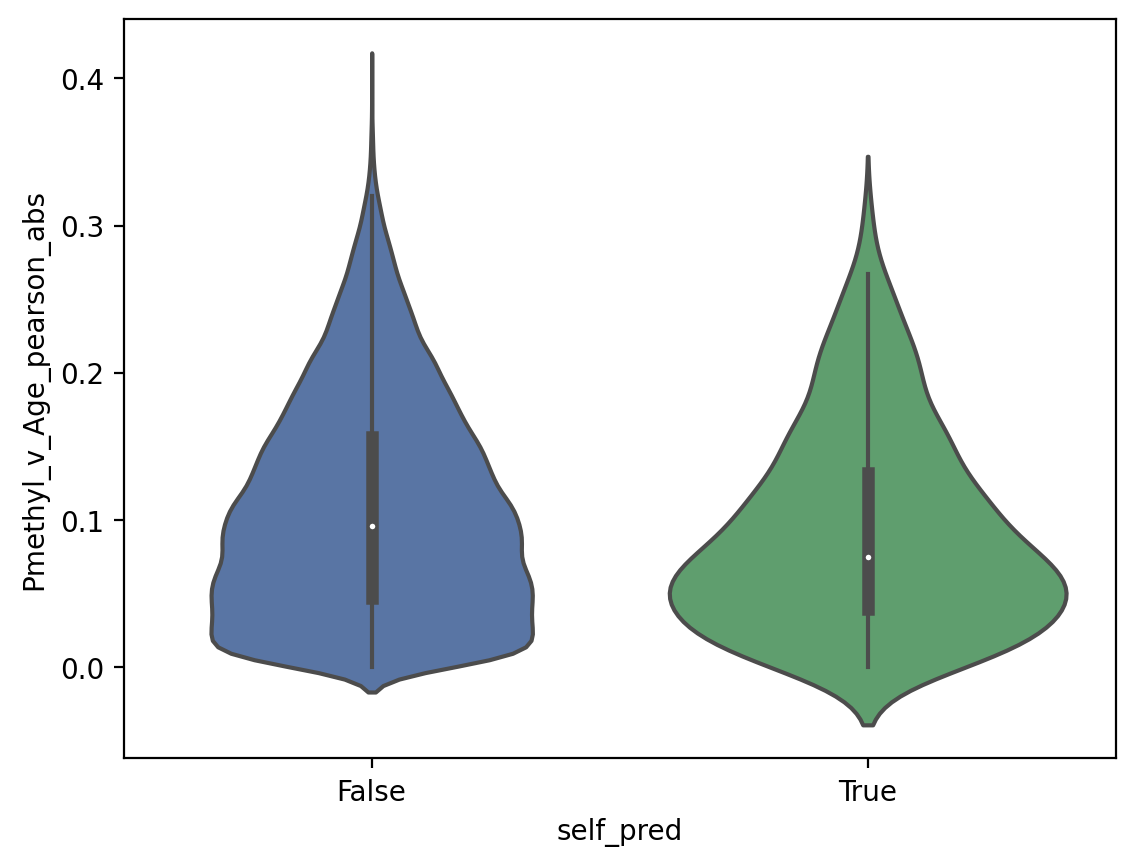

In [53]:
sns.violinplot(data = somage_tcga_coloc_dict[cv_num].performance_by_dataset_df, x = 'self_pred', y = 'Pmethyl_v_Age_pearson_abs')

In [58]:
somage_tcga_coloc_dict[cv_num].performance_by_dataset_df.groupby('self_pred')['AvP_methyl_pearson'].describe()

,count,mean,std,min,25%,50%,75%,max
self_pred,,,,,,,,
False,849826.0,0.059692,0.153961,-0.884854,-0.044407,0.051556,0.156399,0.894498
True,8499.0,0.062402,0.151453,-0.614081,-0.042173,0.052585,0.162818,0.874195


<Axes: xlabel='AvP_methyl_pearson', ylabel='Probability'>

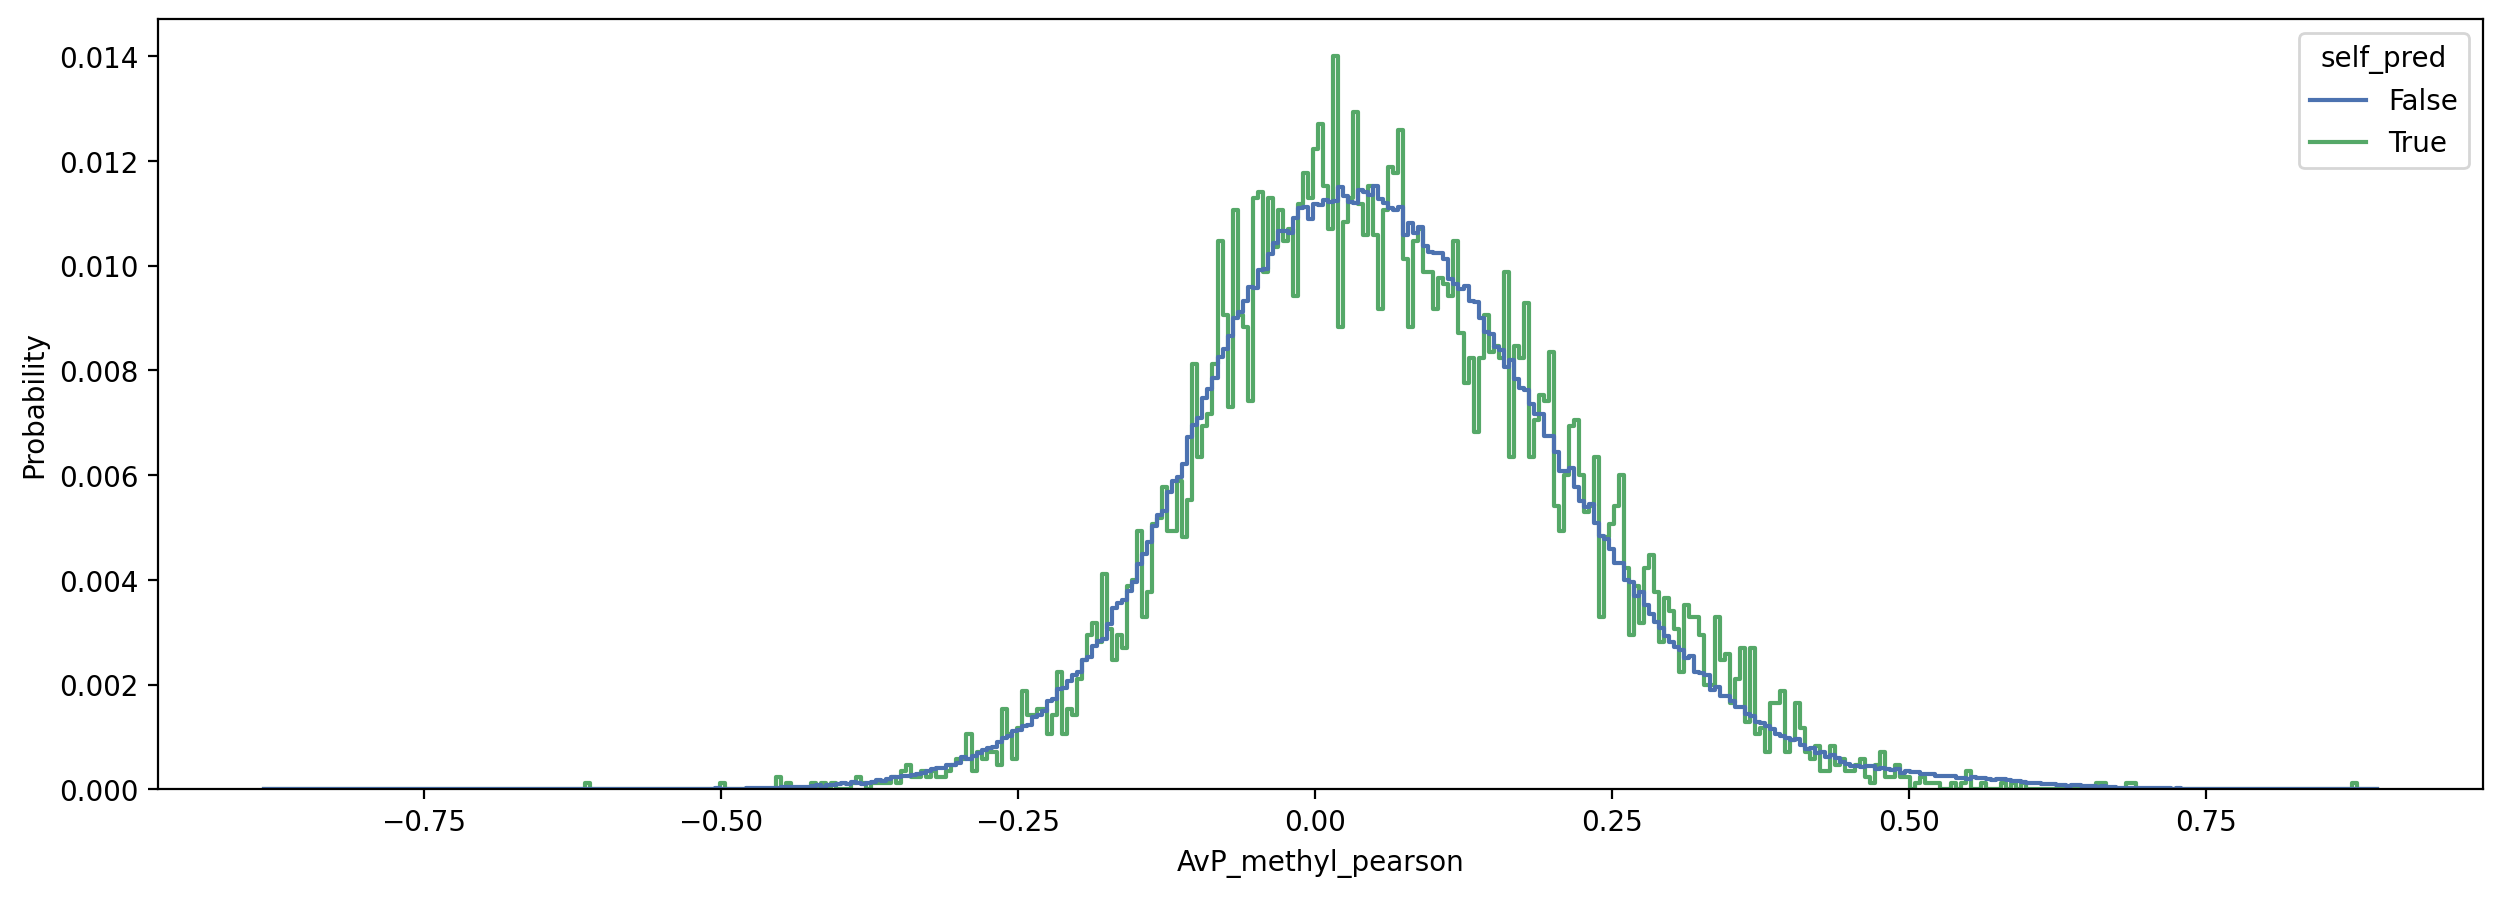

In [70]:
plt.figure(figsize = (15, 5))
sns.histplot(data = somage_tcga_coloc_dict[cv_num].performance_by_dataset_df, x = 'AvP_methyl_pearson', hue = 'self_pred', stat='probability',  common_norm=False, element="step", fill=False)

In [5]:
somage_tcga_coloc_dict[0].predicted_methyl_df

,target_cg20701897_train_cg10792831,target_cg20701897_train_cg06587969,target_cg20701897_train_cg27614485,target_cg20701897_train_cg07899016,target_cg20701897_train_cg26394771,target_cg20701897_train_cg15613340,target_cg20701897_train_cg04503600,target_cg20701897_train_cg24954590,target_cg20701897_train_cg00141260,target_cg20701897_train_cg13307880,...,target_cg22153481_train_cg16263180,target_cg22153481_train_cg19906284,target_cg22153481_train_cg21548029,target_cg22153481_train_cg20649716,target_cg22153481_train_cg27394566,target_cg22153481_train_cg23211470,target_cg22153481_train_cg07745166,target_cg22153481_train_cg20978937,target_cg22153481_train_cg18198734,target_cg22153481_train_cg22153481
TCGA-VP-A87J,0.868585,0.868014,0.865742,0.865288,0.865727,0.865516,0.865194,0.864323,0.865933,0.864571,...,0.026619,0.026308,0.026667,0.026478,0.026433,0.026564,0.026573,0.026498,0.026236,0.026417
TCGA-D9-A1JX,0.673732,0.690915,0.671275,0.654029,0.667233,0.666458,0.672496,0.663781,0.626165,0.677492,...,0.027362,0.027249,0.026881,0.026582,0.027353,0.026776,0.028046,0.026975,0.027181,0.027425
TCGA-T2-A6WZ,0.735863,0.661124,0.755905,0.757551,0.765472,0.766428,0.752454,0.759671,0.762627,0.763636,...,0.031403,0.031651,0.030937,0.031421,0.030533,0.031338,0.031276,0.030530,0.026657,0.030968
TCGA-L5-A4OE,0.729821,0.744536,0.708497,0.746974,0.679157,0.719245,0.686129,0.707752,0.687898,0.725771,...,0.030518,0.031836,0.031866,0.029704,0.028480,0.033364,0.032720,0.028190,0.028522,0.031288
TCGA-OU-A5PI,0.786225,0.802178,0.789802,0.785325,0.795196,0.785027,0.786085,0.790074,0.784198,0.796295,...,0.024537,0.024406,0.024718,0.025853,0.024934,0.025314,0.024436,0.025160,0.024338,0.024581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-HC-A6AN,0.868585,0.868014,0.865742,0.865288,0.865727,0.865516,0.865194,0.864323,0.865933,0.864571,...,0.026619,0.026308,0.026667,0.026478,0.026433,0.026564,0.026573,0.026498,0.026447,0.026417
TCGA-DD-AACJ,0.639589,0.664630,0.681329,0.678557,0.674892,0.677644,0.680421,0.674391,0.666559,0.682303,...,0.026594,0.026317,0.027257,0.027172,0.026739,0.027307,0.026825,0.026600,0.026437,0.026456
TCGA-B5-A3FD,0.701303,0.739932,0.781435,0.778948,0.779621,0.777743,0.776312,0.774973,0.781164,0.777186,...,0.031262,0.028377,0.030916,0.030566,0.029747,0.031647,0.031265,0.029191,0.028208,0.030577
TCGA-MH-A55W,0.754739,0.752199,0.752385,0.752828,0.751088,0.754156,0.751673,0.751505,0.745946,0.753790,...,0.030155,0.029173,0.029594,0.029560,0.029521,0.029458,0.028842,0.029439,0.028314,0.028956


# Feature creation, with/without GPU

#### TCGA testing JIT

In [7]:
motif_occurence_df = pd.read_parquet(
        "/cellar/users/zkoch/methylation_and_mutation/data/methylation_motifs_weiWang/motif_occurences/motif_occurences_combined_15kb.parquet"
        )

In [42]:
mut_feat_tcga = mutation_features.mutationFeatures(
            all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
            all_methyl_age_df_t = all_methyl_age_df_t, out_dir = "./", 
            consortium = 'TCGA', dataset = '', cross_val_num = 0,
            matrix_qtl_dir = matrix_qtl_dir,
            covariate_fn = covariate_fn, motif_occurence_df = motif_occurence_df
        )

In [58]:
mut_feat_params = {
        'bin_size': 25000, 'aggregate': 'Both', 
        'num_correl_sites' : 500, 'max_meqtl_sites' : 0,
        'nearby_window_size' : 50000, 'extend_amount' : 500
    }
mut_feat_tcga.create_all_feat_mats(
    cpg_ids = all_methyl_age_df_t.columns[3:6].tolist(), 
    aggregate = mut_feat_params['aggregate'],
    num_correl_sites = mut_feat_params['num_correl_sites'], 
    max_meqtl_sites=mut_feat_params['max_meqtl_sites'],
    nearby_window_size = mut_feat_params['nearby_window_size'], 
    extend_amount = mut_feat_params['extend_amount'] 
    )
# 2 min for 3 cpgs
# 1:46 for 3 cpgs
# 2:35 for 5 new way
# 2:56 for 5 old corr way

Finished 0 of 3


In [ ]:
# each takes 10 hours
# 273 jobs => 2730 hours => 114 days


In [59]:
mut_feat_store_fn = mut_feat_tcga.save_mutation_features(
    start_top_cpgs = 3
    )

Saved mutation features to
./TCGA__500correl_0meqtl_50000nearby_Bothagg_8numCpGs_3startTopCpGs_500extendAmount_0crossValNum/TCGA__500correl_0meqtl_50000nearby_Bothagg_8numCpGs_3startTopCpGs_500extendAmount_0crossValNum.features.pkl


# MI calculation

In [115]:
mi_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/dependency_files/mutual_informations/tcga_combinedMI_top10MI.parquet")

In [123]:
from sklearn.feature_selection import mutual_info_regression
import itertools


In [121]:
chr1_cpgs = illumina_cpg_locs_df.query("chr == '1'")['#id'].values
methyl_cpgs = all_methyl_age_df_t.columns.values
chr1_methyl_cpgs = np.intersect1d(chr1_cpgs, methyl_cpgs)
chr1_methyl_df = all_methyl_age_df_t.loc[:,chr1_methyl_cpgs]

In [161]:
rounded_X = chr1_methyl_df.iloc[:,1:1000].round(2).values
rounded_y = chr1_methyl_df.iloc[:,0].round(2).values

In [177]:
# 38.2s looping instead of all at once, continuous
for i in range(0,25):
    _ = mutual_info_regression(
        X = chr1_methyl_df.iloc[:,:25].values,
        y = chr1_methyl_df.iloc[:,i].ravel(),
        discrete_features=False,
    )

In [255]:
for cpg in chr1_methyl_cpgs[:2]:
    x = mutual_info_regression(
        X = chr1_methyl_df.iloc[:, :10].values,
        y = chr1_methyl_df[cpg].ravel(),
        discrete_features=False,
        )
    print(x)

[7.80407235e+00 5.29834094e-02 1.80686306e-02 1.71834767e-02
 1.33573265e-02 7.23358702e-02 4.92744812e-02 1.20717811e-01
 6.55387586e-03 7.34577261e-02]
[5.29769052e-02 7.80009769e+00 4.03198309e-02 4.81512725e-03
 5.31317305e-03 7.04432188e-02 6.29536150e-02 3.36660132e-02
 4.35351003e-02 7.98836193e-02]


In [175]:
# for the np.array chr1_methyl_cpgs, get all possible pairwise combinations
cpg_pairs = list(itertools.combinations(chr1_methyl_cpgs[:25], 2))
for i, j in cpg_pairs:
    _ = mutual_info_regression(
        X = chr1_methyl_df[i].values.reshape(-1,1),
        y = chr1_methyl_df[j].ravel(),
        discrete_features=False,
        )

In [259]:
mi_rez

,cg00000165,cg00000363,cg00000957,cg00001349,cg00001446,cg00001583,cg00002593,cg00002719,cg00002808,cg00002810,...,cg00003287,cg00003345,cg00003578,cg00004121,cg00004209,cg00006198,cg00006397,cg00006626,cg00007036,cg00007221
cg00000165,7.804708,0.052955,0.018077,0.017177,0.013375,0.072328,0.049302,0.120735,0.006534,0.073446,...,0.050391,0.034352,0.039228,0.035222,0.026889,0.013045,0.041333,0.028290,0.000000,0.025012
cg00000363,0.052974,7.799207,0.040300,0.004871,0.005297,0.070459,0.062942,0.033624,0.043530,0.079897,...,0.044284,0.105072,0.067422,0.051110,0.013279,0.017518,0.032787,0.028176,0.004343,0.071265
cg00000957,0.018080,0.040338,7.797536,0.033760,0.004712,0.025946,0.005975,0.030383,0.000000,0.011315,...,0.023023,0.018462,0.021345,0.041238,0.001983,0.010793,0.026322,0.014635,0.003664,0.002872
cg00001349,0.017158,0.004837,0.033747,7.804533,0.015744,0.016013,0.006200,0.020978,0.007262,0.016203,...,0.020832,0.000000,0.000000,0.045019,0.010370,0.013218,0.028418,0.024363,0.013974,0.007244
cg00001446,0.013388,0.005300,0.004659,0.015765,7.800359,0.019417,0.004694,0.009222,0.006765,0.012573,...,0.027994,0.002456,0.002725,0.012531,0.012520,0.011167,0.008669,0.006606,0.006774,0.016039
cg00001583,0.072312,0.070465,0.025900,0.016028,0.019439,7.805704,0.067245,0.146324,0.017616,0.066984,...,0.047784,0.071650,0.034870,0.005677,0.017759,0.024257,0.041421,0.018204,0.000000,0.063712
cg00002593,0.049301,0.062925,0.005963,0.006216,0.004649,0.067256,7.806213,0.134064,0.006277,0.060687,...,0.042005,0.114379,0.038256,0.023123,0.023501,0.000000,0.044660,0.011873,0.000309,0.114987
cg00002719,0.120722,0.033666,0.030356,0.020958,0.009226,0.146370,0.134041,7.805931,0.012467,0.121152,...,0.076573,0.114341,0.053748,0.040277,0.022426,0.048790,0.092796,0.069914,0.019577,0.107230
cg00002808,0.006550,0.043518,0.000000,0.007270,0.006789,0.017666,0.006297,0.012475,7.794153,0.020288,...,0.018982,0.041507,0.032499,0.000000,0.000000,0.018949,0.019984,0.014117,0.000000,0.029177
cg00002810,0.073459,0.079893,0.011278,0.016181,0.012540,0.066954,0.060641,0.121107,0.020358,7.796135,...,0.100793,0.093081,0.019240,0.119199,0.023635,0.044758,0.073092,0.043576,0.007312,0.041503


In [217]:
mi_rez.to_parquet(
    '/cellar/users/zkoch/methylation_and_mutation/dependency_files/all_mi_chrom1_PANCAN.parquet'
    )

In [223]:
test_mi_rez_df = pd.read_parquet(
    '/cellar/users/zkoch/methylation_and_mutation/dependency_files/test_all_mi_chrom1_PANCAN.parquet'
)

In [224]:
test_mi_rez_df

,cpg1,cpg2,mi
0,cg00000165,cg00000363,0.052954
1,cg00000165,cg00000957,0.018028
2,cg00000165,cg00001349,0.017164
3,cg00000165,cg00001446,0.013358
4,cg00000165,cg00001583,0.072330
...,...,...,...
205,cg00006397,cg00007036,0.015690
206,cg00006397,cg00007221,0.035600
207,cg00006626,cg00007036,0.021057
208,cg00006626,cg00007221,0.015496


In [185]:
# import csr_matrix
import scipy.sparse as sp

In [192]:
# reshape mi_rez from long to wide format
mi_rez_wide = mi_rez.pivot_table(index='cpg1', columns='cpg2', values='mi')

In [197]:
((26000/77) *2)/60

11.255411255411255

In [194]:
mi_rez_wide

cpg2,cg00000363,cg00000957,cg00001349,cg00001446,cg00001583,cg00002593,cg00002719,cg00002808,cg00002810,cg00002837,...,cg00031063,cg00031456,cg00033127,cg00034101,cg00034416,cg00034433,cg00034468,cg00034556,cg00035237,cg00035249
cpg1,,,,,,,,,,,,,,,,,,,,,
cg00000165,0.05298,0.018064,0.017171,0.013358,0.072340,0.049289,0.120710,0.006568,0.073454,0.037565,...,0.000000,0.002362,0.007938,0.044915,0.019913,0.014908,0.120350,0.047153,0.012818,0.017766
cg00000363,NaN,0.040361,0.004860,0.005309,0.070460,0.062925,0.033619,0.043555,0.079895,0.062910,...,0.030616,0.000000,0.000367,0.095345,0.003975,0.032269,0.040692,0.049691,0.026106,0.006453
cg00000957,NaN,NaN,0.033726,0.004669,0.025925,0.005996,0.030385,0.000000,0.011302,0.016371,...,0.041311,0.008606,0.000000,0.024395,0.002148,0.013061,0.015007,0.024295,0.004278,0.010647
cg00001349,NaN,NaN,NaN,0.015708,0.016045,0.006239,0.021018,0.007277,0.016181,0.007039,...,0.036303,0.008997,0.000000,0.015654,0.000000,0.003635,0.031456,0.005200,0.000000,0.018408
cg00001446,NaN,NaN,NaN,NaN,0.019453,0.004653,0.009238,0.006858,0.012510,0.005151,...,0.008364,0.000000,0.004287,0.004456,0.000000,0.017613,0.018421,0.025609,0.004438,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg00034416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.016379,0.002682,0.004415,0.016249,0.009463
cg00034433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.044378,0.011694,0.000000,0.003331
cg00034468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.049109,0.024383,0.000000


In [189]:
mi_rez_wide_sparse.todense()

matrix([[0.05296854, 0.01809554, 0.01717562, 0.01334592, 0.07234239,
         0.04930358, 0.12073277, 0.00655566, 0.07343317, 0.03758203,
         0.05038696, 0.03437443, 0.03921737, 0.03521563, 0.02688736,
         0.01304007, 0.04133928, 0.02828037, 0.        , 0.02500677],
        [       nan, 0.04031844, 0.00483655, 0.0053169 , 0.07042338,
         0.06294292, 0.03368553, 0.04352379, 0.07985235, 0.06288923,
         0.04431749, 0.10508481, 0.06741359, 0.05107332, 0.01324493,
         0.01752212, 0.03276542, 0.02815873, 0.00441156, 0.07127229],
        [       nan,        nan, 0.03373455, 0.0046871 , 0.02593369,
         0.00599321, 0.03039204, 0.        , 0.01128385, 0.01638647,
         0.02297745, 0.01844539, 0.02132761, 0.0412253 , 0.0019695 ,
         0.01079133, 0.02630437, 0.01461092, 0.00358557, 0.0028824 ],
        [       nan,        nan,        nan, 0.01574383, 0.01600491,
         0.00623291, 0.02101133, 0.00725437, 0.01619904, 0.00705853,
         0.02084739, 0.        